In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [42]:
import tensorflow as tf
import numpy as np
import sentencepiece as spm
from tqdm import tqdm
import seaborn
from sklearn.model_selection import train_test_split

import os, re
import random

In [43]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 데이터 전처리

In [44]:
# data_dir = os.getenv('HOME')+'/Desktop/Quest05/data'
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    assert len(kor) == len(eng)

    unique_pairs = set(zip(kor, eng))
    cleaned_corpus = list(unique_pairs)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [45]:
def preprocess_sentence(sentence, lang='en'):
    # 소문자로 변환
    sentence = sentence.lower()
    
    sentence = re.sub(r"\([^)]*\)", "", sentence)  # 괄호로 닫힌 문자열 제거
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    
    if lang == 'en':
        # 특수기호 변경
        sentence = re.sub(r"\$", "dollars ", sentence)  # $ → dollars
        sentence = re.sub(r"%", " percents", sentence)  # % → percent
        sentence = re.sub(r"&", "and", sentence)  # & → and
    
    if lang == 'ko':
        sentence = re.sub(r"%", "퍼센트", sentence)  # % → 퍼센트
    
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣!?]", " ", sentence)
    
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([!?])", r" \1 ", sentence)
    
    # 연속된 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [46]:
eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k, 'ko'))
    eng_corpus.append(preprocess_sentence(e, 'en'))

In [47]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    # 임시 파일에 말뭉치를 저장
    corpus_file = f"{lang}_corpus.txt"
    model_prefix = f"{lang}_tokenizer"

    with open(corpus_file, "w", encoding="utf-8") as f:
        for sentence in corpus:
            f.write(sentence + "\n")

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.Train(input=corpus_file,
                                   model_prefix=model_prefix,
                                   vocab_size=vocab_size,
                                   pad_id=pad_id,
                                   bos_id=bos_id,
                                   eos_id=eos_id,
                                   unk_id=unk_id,
                                   model_type="unigram")
    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_prefix}.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  esc

True

M sub_iter=1 size=21997 obj=7.83847 num_tokens=82203 num_tokens/piece=3.73701
trainer_interface.cc(615) LOG(INFO) Saving model: en_tokenizer.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: en_tokenizer.vocab


In [48]:
src_corpus = []
tgt_corpus = []

max_len = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    tokenized_kor = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tokenized_eng = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(tokenized_kor) <= max_len and len(tokenized_eng) <= max_len:
        src_corpus.append(tokenized_kor)
        tgt_corpus.append(tokenized_eng)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:04<00:00, 16949.37it/s]


In [49]:
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_train, dec_train, test_size=0.05)

In [50]:
print(enc_train.shape)
print(enc_val.shape)

(72773, 50)
(3831, 50)


#### 모델 설계

In [51]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [52]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        # # Dense 레이어는 학습 가능한 가중치 행렬을 이용하여 입력을 변환 
        self.W_q = tf.keras.layers.Dense(d_model) 
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)  # K.shape[-1] : k_dim
        
        QK = tf.matmul(Q, K, transpose_b=True) # Query, Key 유사도 계산
        scaled_qk = QK / tf.math.sqrt(d_k)
        

        # Masking: mask가 주어진 경우, 마스크된 값에 대해 큰 음수 값(-1e9)을 더하여 softmax 계산 시 무시
        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        # Softmax: Attention Weights를 계산하여, 각 값에 대해 중요도
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
#         x: [ batch x length x emb ]
#         return: [ batch x heads x length x self.depth ]
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0,2,1,3])

        return split_x

    def combine_heads(self, x):
#         x: [ batch x heads x length x self.depth ]
#         return: [ batch x length x emb ]
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0,2,1,3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

In [53]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [54]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [55]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads) #num_heads
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, dec_attn, dec_enc_attn

In [56]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [57]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [58]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: 
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [59]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_target_padding_mask = generate_padding_mask(tgt)
    look_ahead_mask = generate_causality_mask(tf.shape(tgt)[1])
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    dec_enc_mask = enc_mask
    return enc_mask, combined_mask, dec_enc_mask

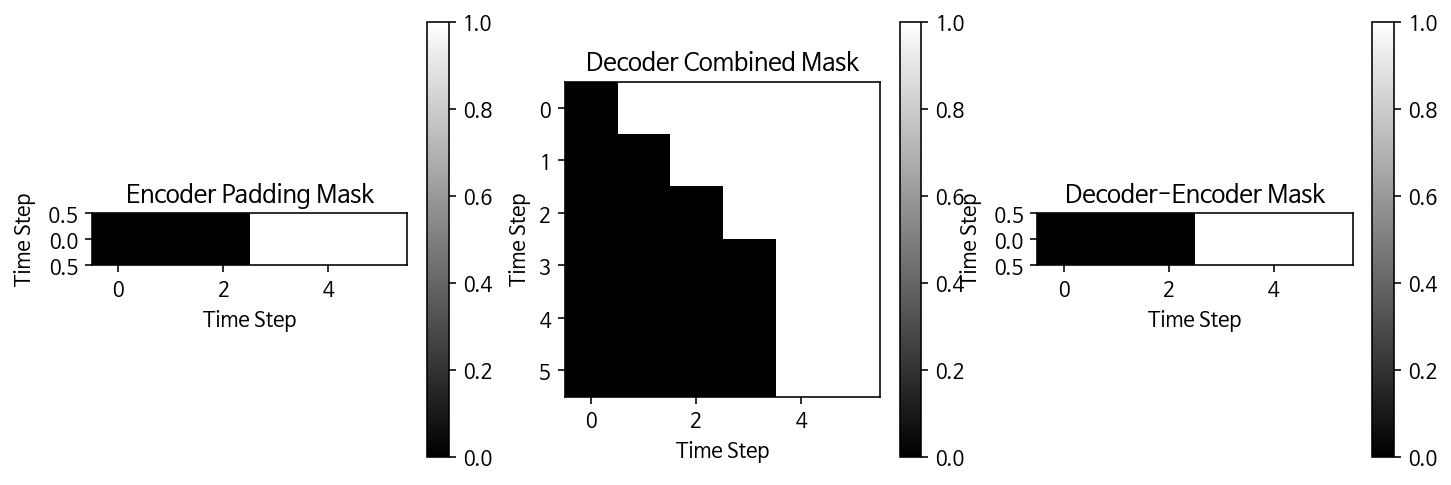

In [60]:
# 샘플 입력 데이터
src = tf.constant([[7, 6, 8, 0, 0, 0]])  # 패딩 포함
tgt = tf.constant([[1, 2, 3, 4, 0, 0]])     # 패딩 포함

# 마스크 생성
enc_mask, combined_mask, dec_enc_mask = generate_masks(src, tgt)

masks = [enc_mask[0, 0].numpy(), combined_mask[0].numpy().squeeze(), dec_enc_mask[0, 0].numpy()]
titles = ['Encoder Padding Mask', 'Decoder Combined Mask', 'Decoder-Encoder Mask']

plt.figure(figsize=(12, 4))
for i, mask in enumerate(masks):
    plt.subplot(1, 3, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(titles[i])
    plt.xlabel('Time Step')
    plt.ylabel('Time Step')
    plt.colorbar()
plt.show()

#### 모델 학습

In [61]:
D_MODEL = 256

transformer = Transformer(n_layers=3,
                          d_model=D_MODEL, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=20000,
                          tgt_vocab_size=20000,
                          dropout=0.4,
                          pos_len=max_len)

In [62]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [63]:
learning_rate = LearningRateScheduler(D_MODEL, warmup_steps=2000)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [64]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [65]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [66]:
@tf.function()
def eval_step(src, tgt, model):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 예측 결과를 계산합니다. GradientTape는 사용하지 않습니다.
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    
    # 손실 계산
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [67]:
# Attention 시각화 
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [68]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns


# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [69]:
BATCH_SIZE = 128
EPOCHS = 5
import random

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    total_val_loss = 0  # Validation loss 초기화
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    # Training 단계
    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    # Validation 단계
    for idx in range(0, enc_val.shape[0], BATCH_SIZE):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE], 
                  dec_val[idx:idx+BATCH_SIZE], 
                  transformer)
        total_val_loss += batch_loss

    avg_val_loss = total_val_loss / (enc_val.shape[0] // BATCH_SIZE)
    print(f"Epoch {epoch + 1}: Validation Loss {avg_val_loss.numpy():.4f}")
    
    if (epoch + 1) % 2 == 0:
        for example in examples:
            translate(example, transformer, ko_tokenizer, en_tokenizer, False)

Epoch  1: 100%|██████████| 569/569 [02:21<00:00,  4.01it/s, Loss 6.7660]


Epoch 1: Validation Loss 5.8964


Epoch  2: 100%|██████████| 569/569 [02:15<00:00,  4.21it/s, Loss 5.2158]


Epoch 2: Validation Loss 5.1393
Input: 오바마는 대통령이다.
Predicted translation: obama president roh moo hyun is president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city of the city
Input: 커피는 필요 없다.
Predicted translation: coffee is not a good goal
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll toll was killed in the past two days


Epoch  3: 100%|██████████| 569/569 [02:14<00:00,  4.22it/s, Loss 4.5233]


Epoch 3: Validation Loss 4.8298


Epoch  4: 100%|██████████| 569/569 [02:14<00:00,  4.22it/s, Loss 4.0273]


Epoch 4: Validation Loss 4.6699
Input: 오바마는 대통령이다.
Predicted translation: obama is president barack obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of downtown city
Input: 커피는 필요 없다.
Predicted translation: don t need to be a coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll was reported saturday


Epoch  5: 100%|██████████| 569/569 [02:14<00:00,  4.22it/s, Loss 3.4201]


Epoch 5: Validation Loss 4.6274


Input: 오바마는 전 대통령이다.
Predicted translation: obama is a former president
Encoder Layer 1


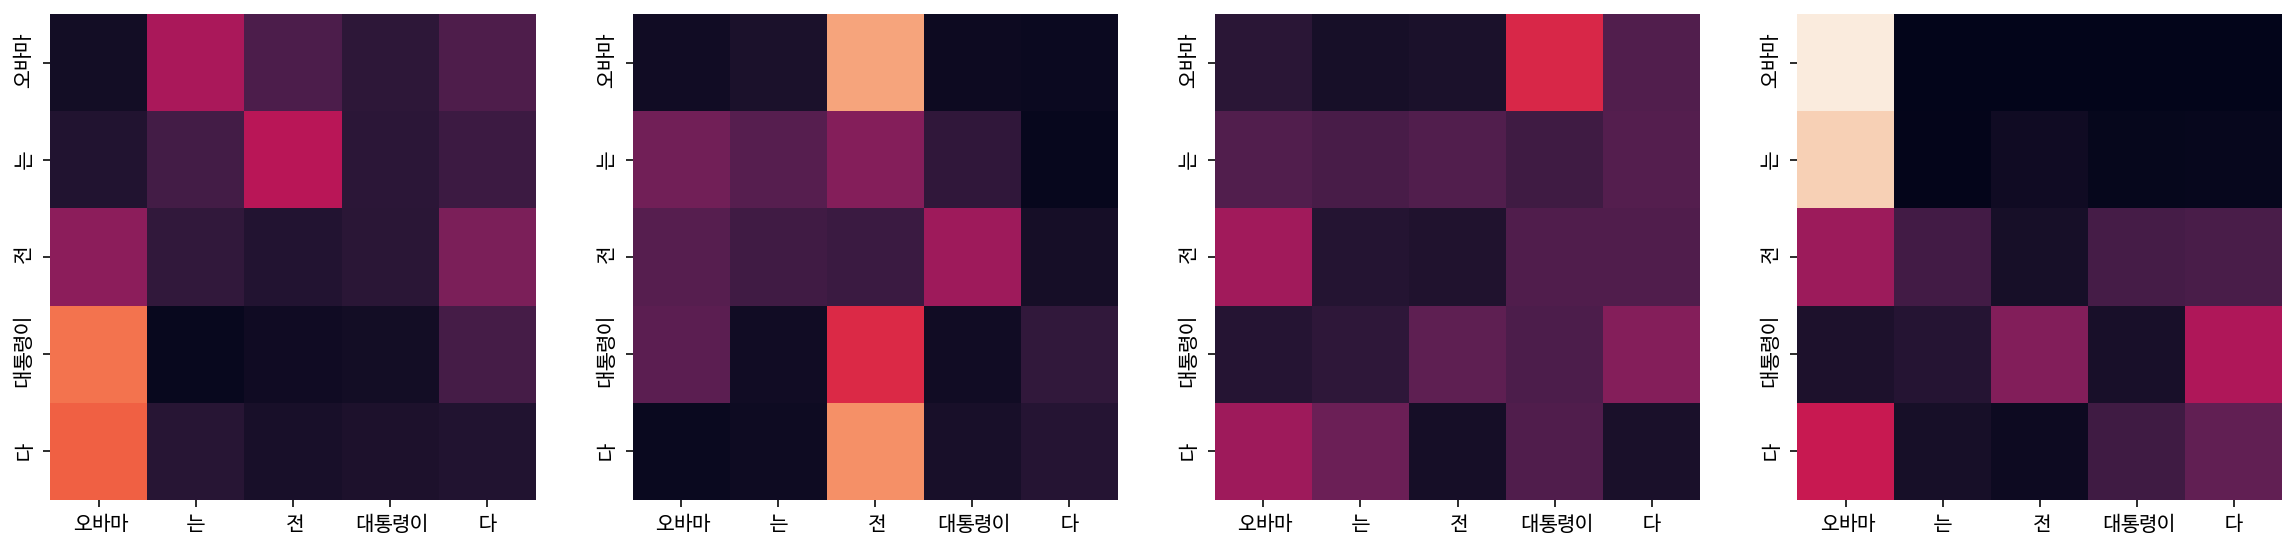

Encoder Layer 2


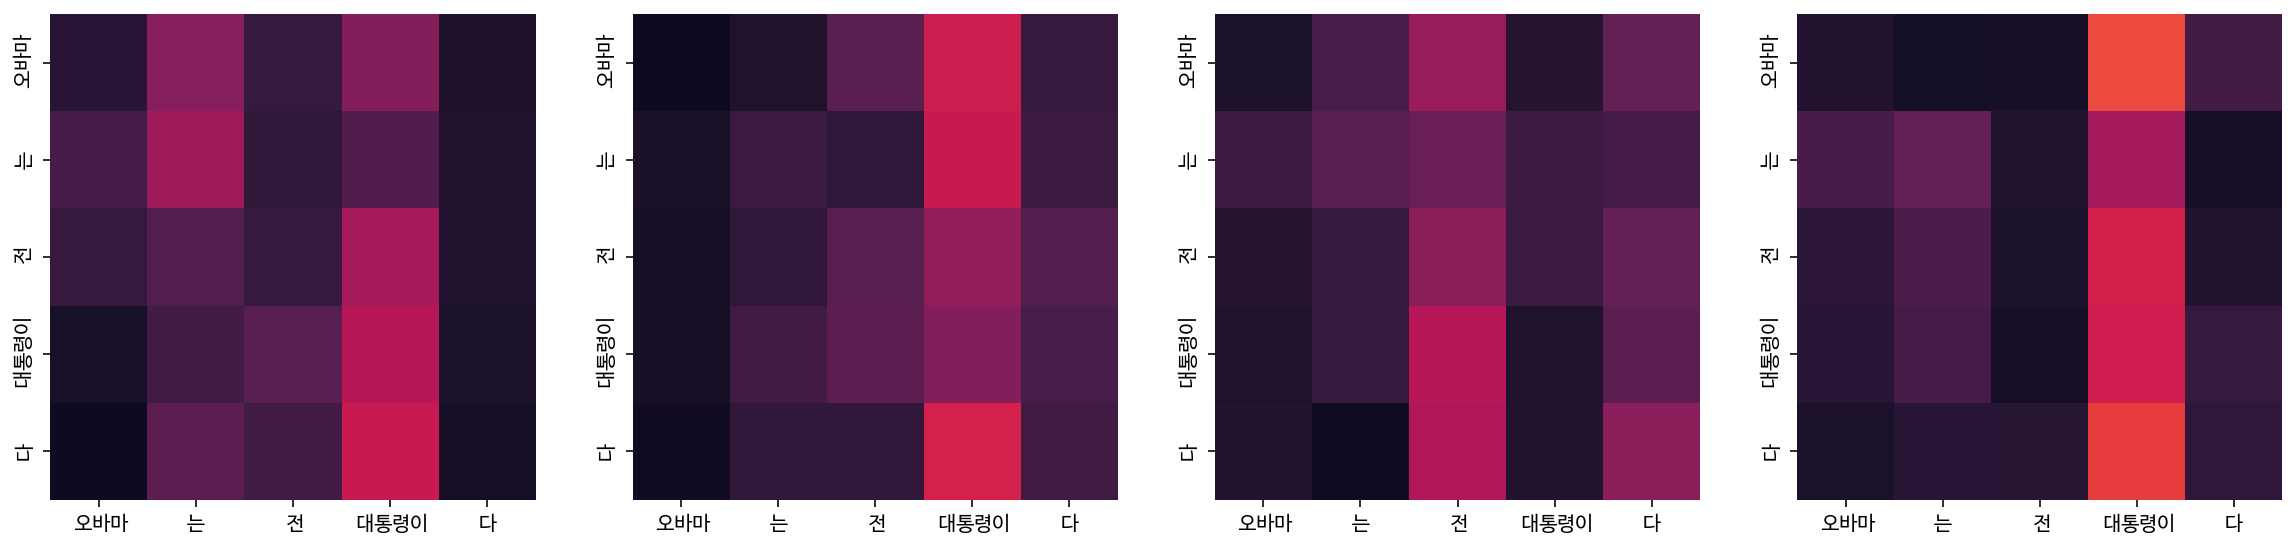

Decoder Self Layer 1


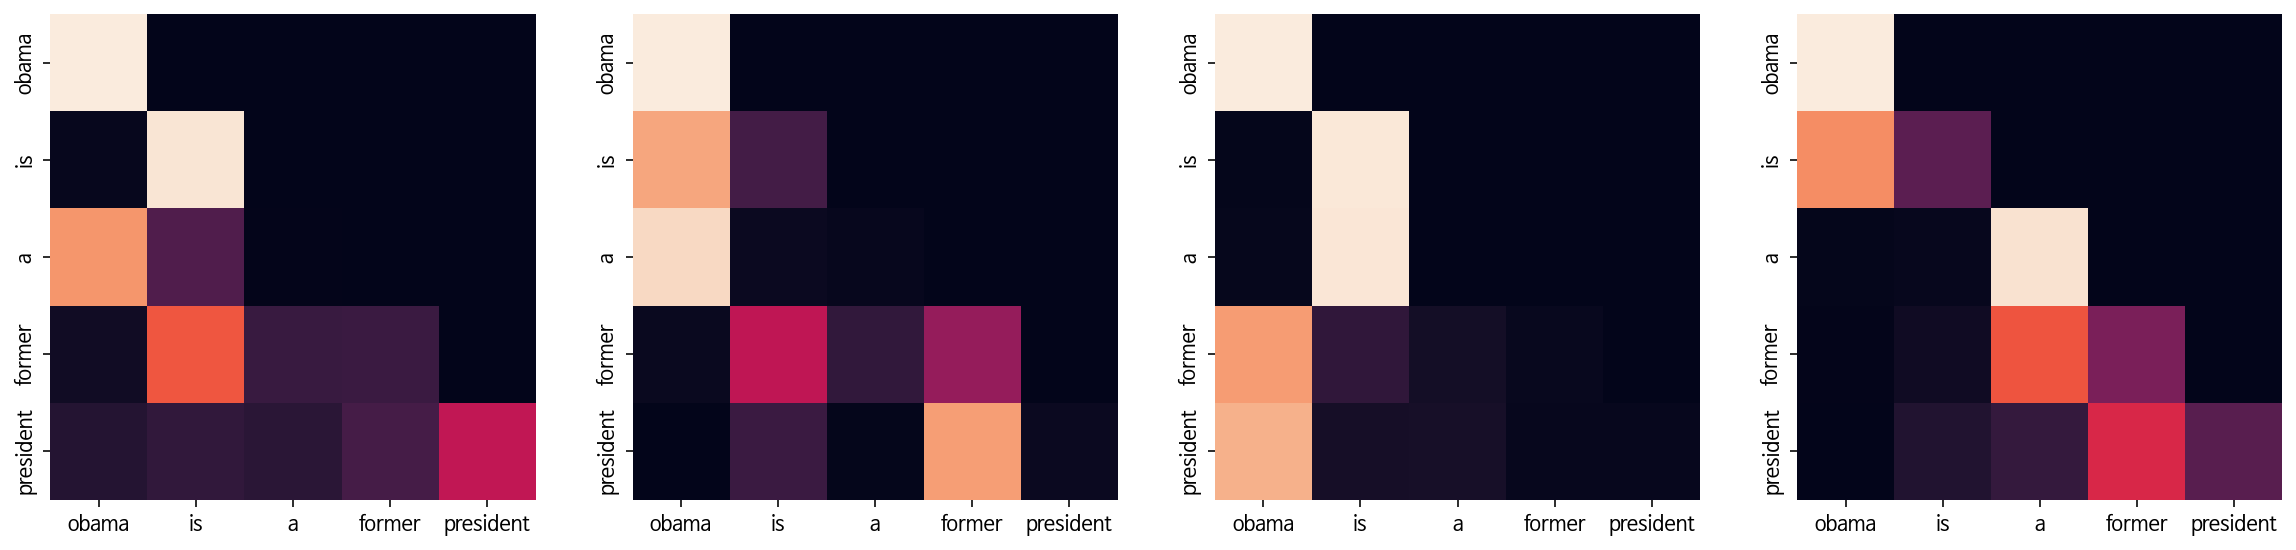

Decoder Src Layer 1


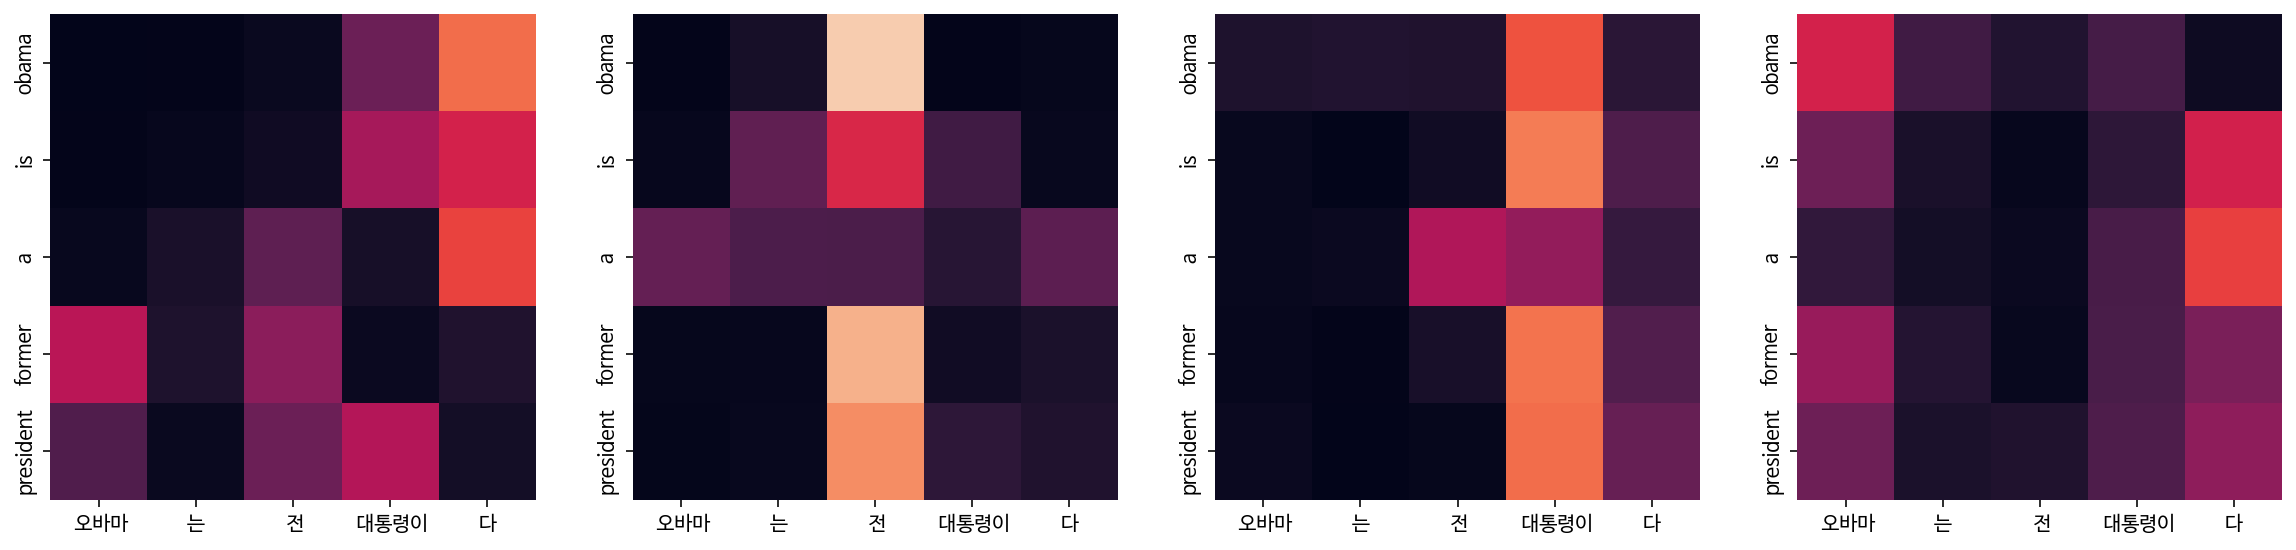

Decoder Self Layer 2


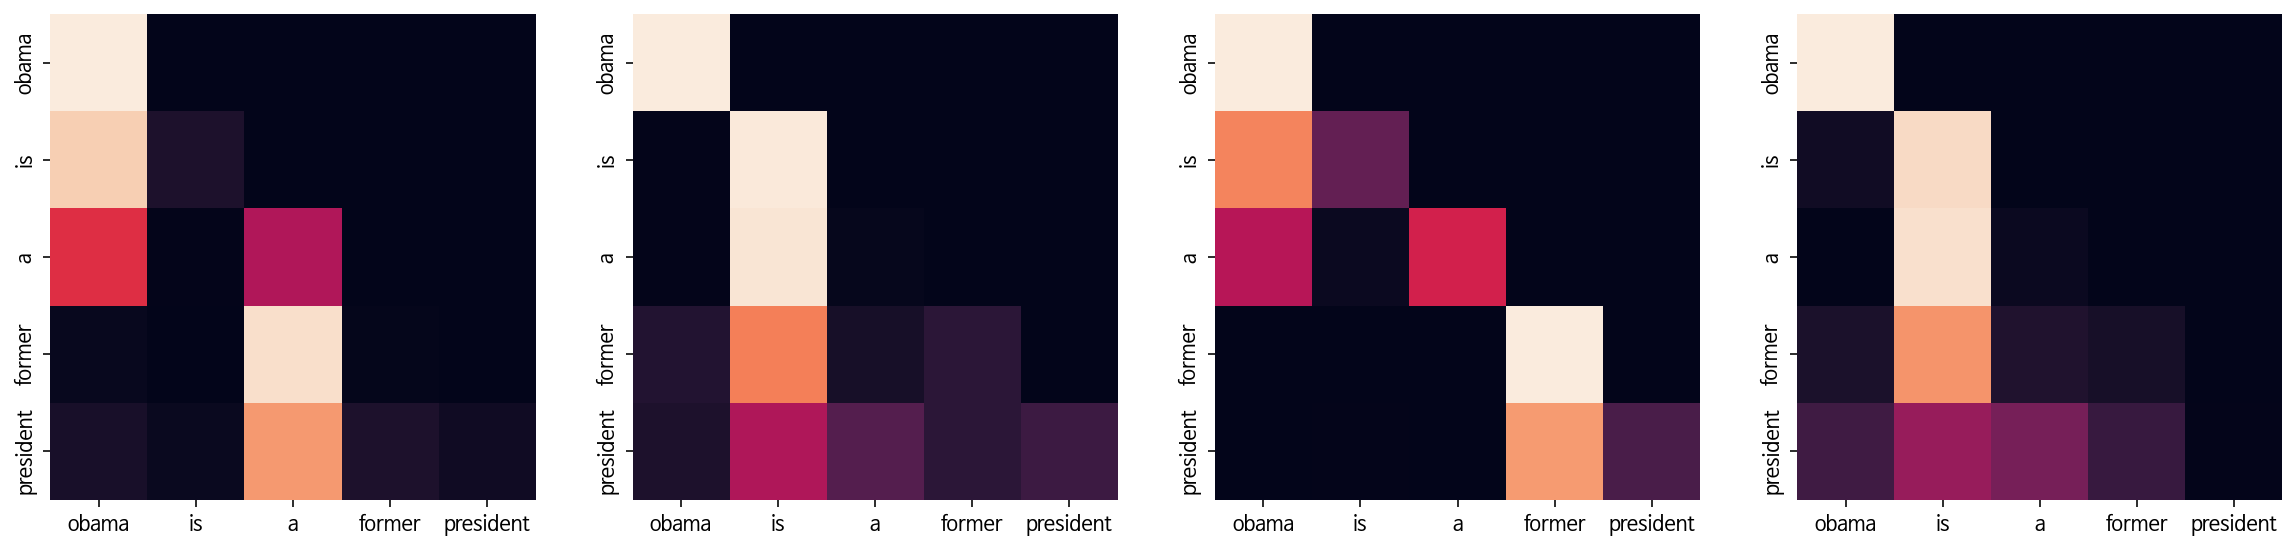

Decoder Src Layer 2


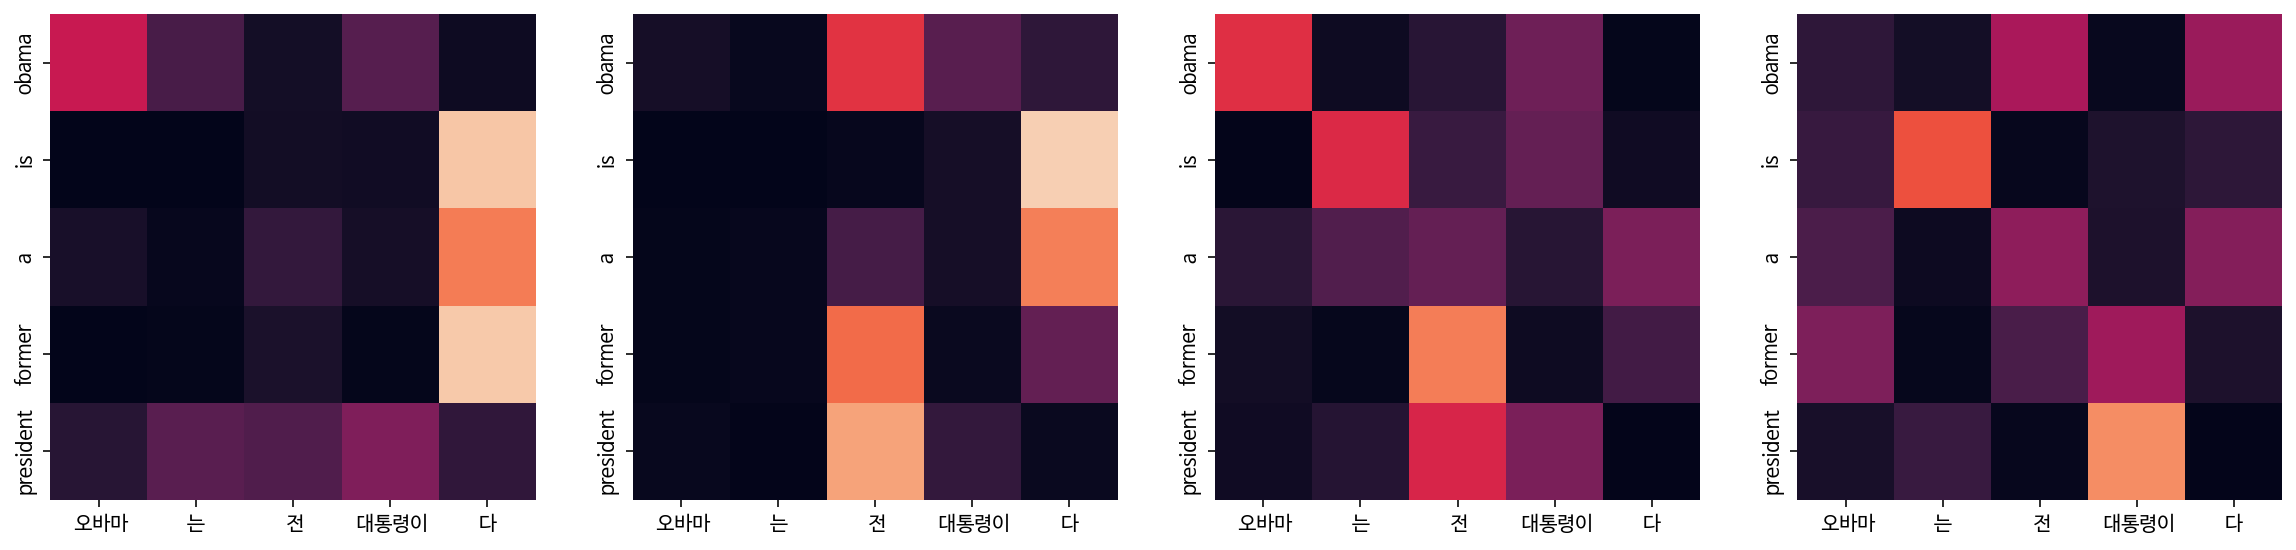

Input: 시민들이 도시에 산다.
Predicted translation: citizens in cities city city
Encoder Layer 1


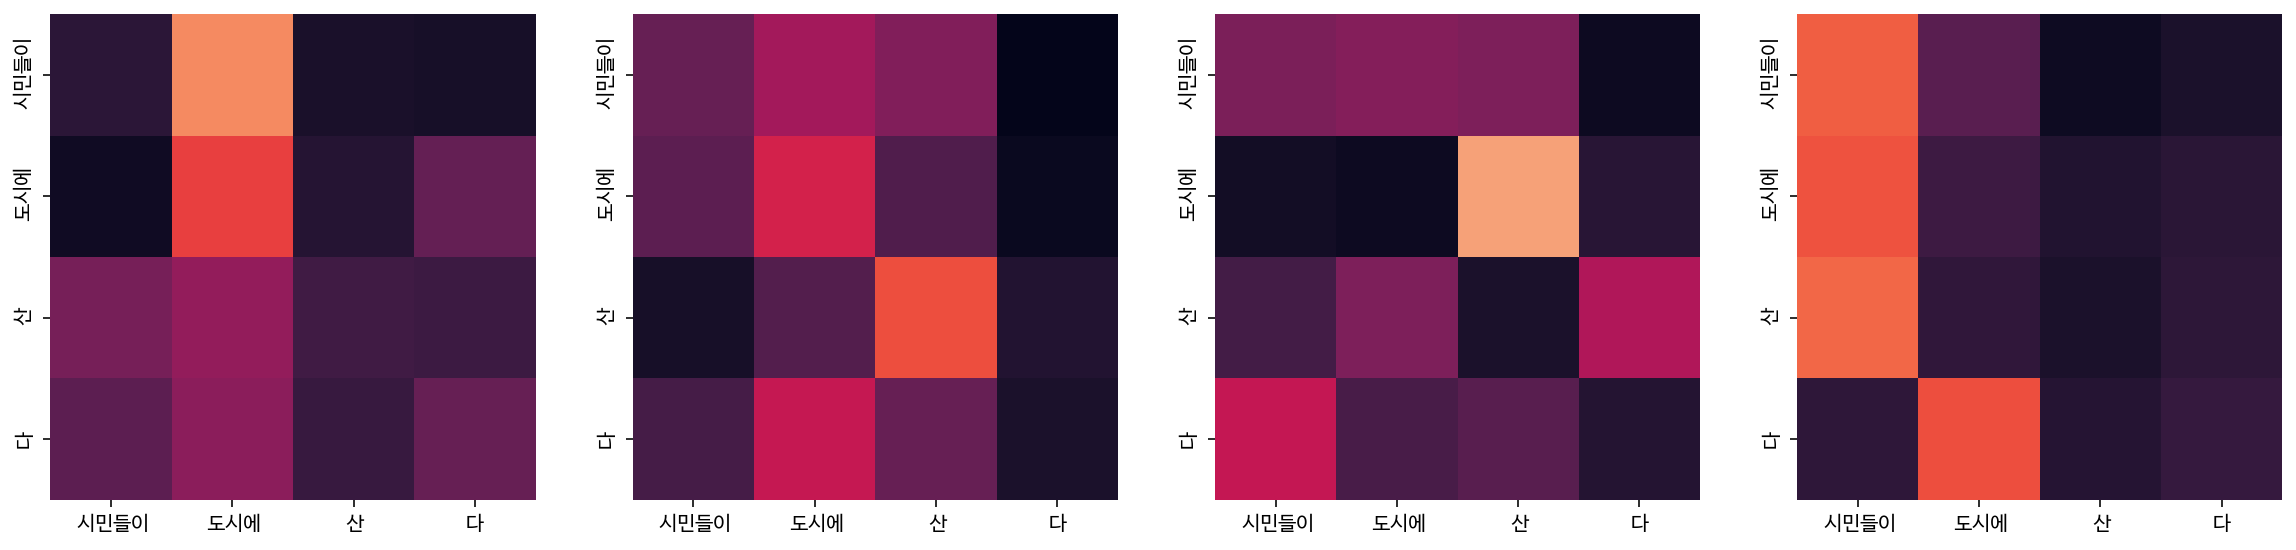

Encoder Layer 2


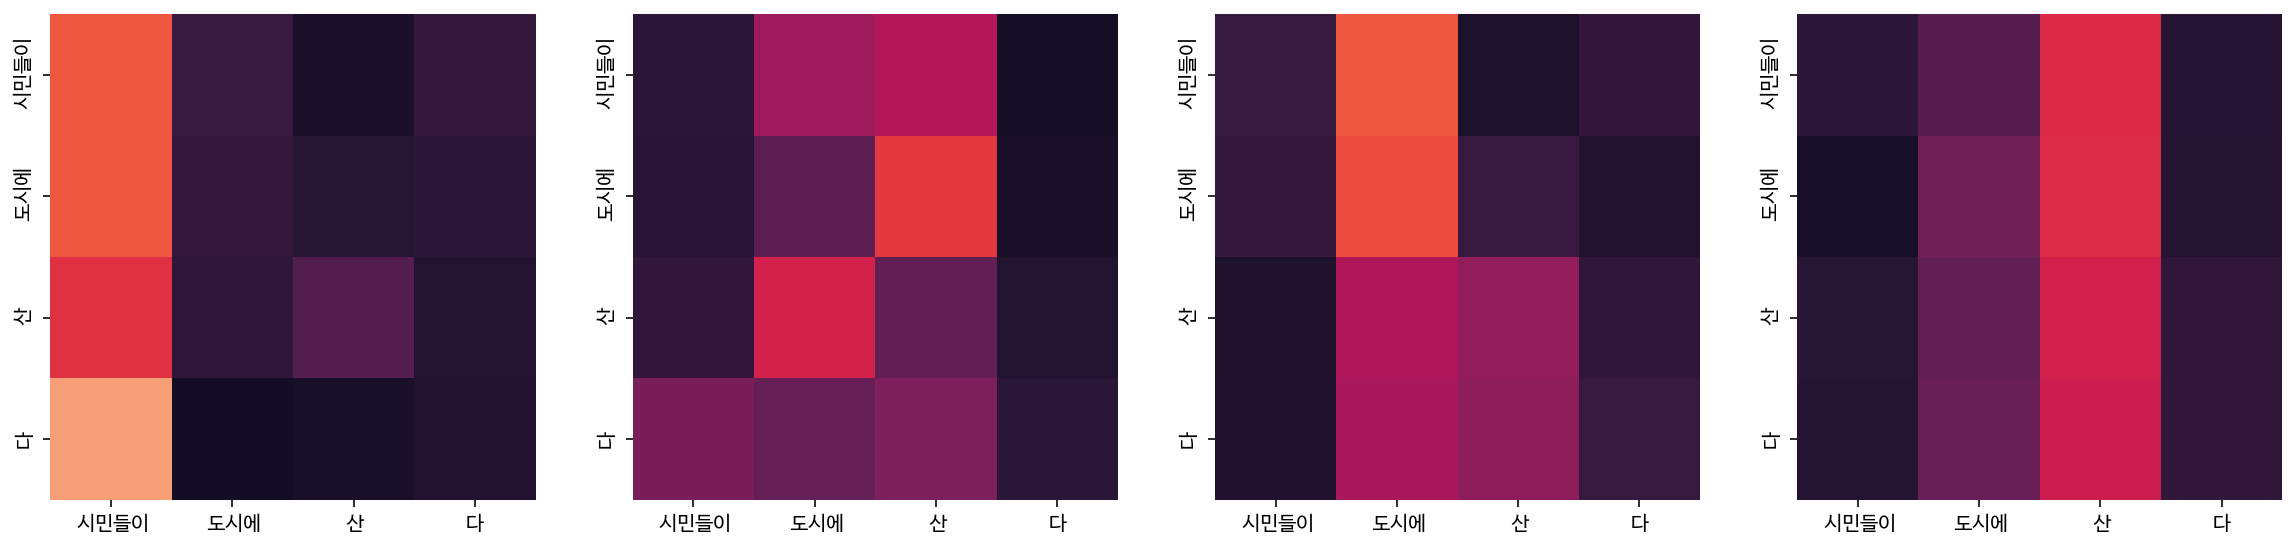

Decoder Self Layer 1


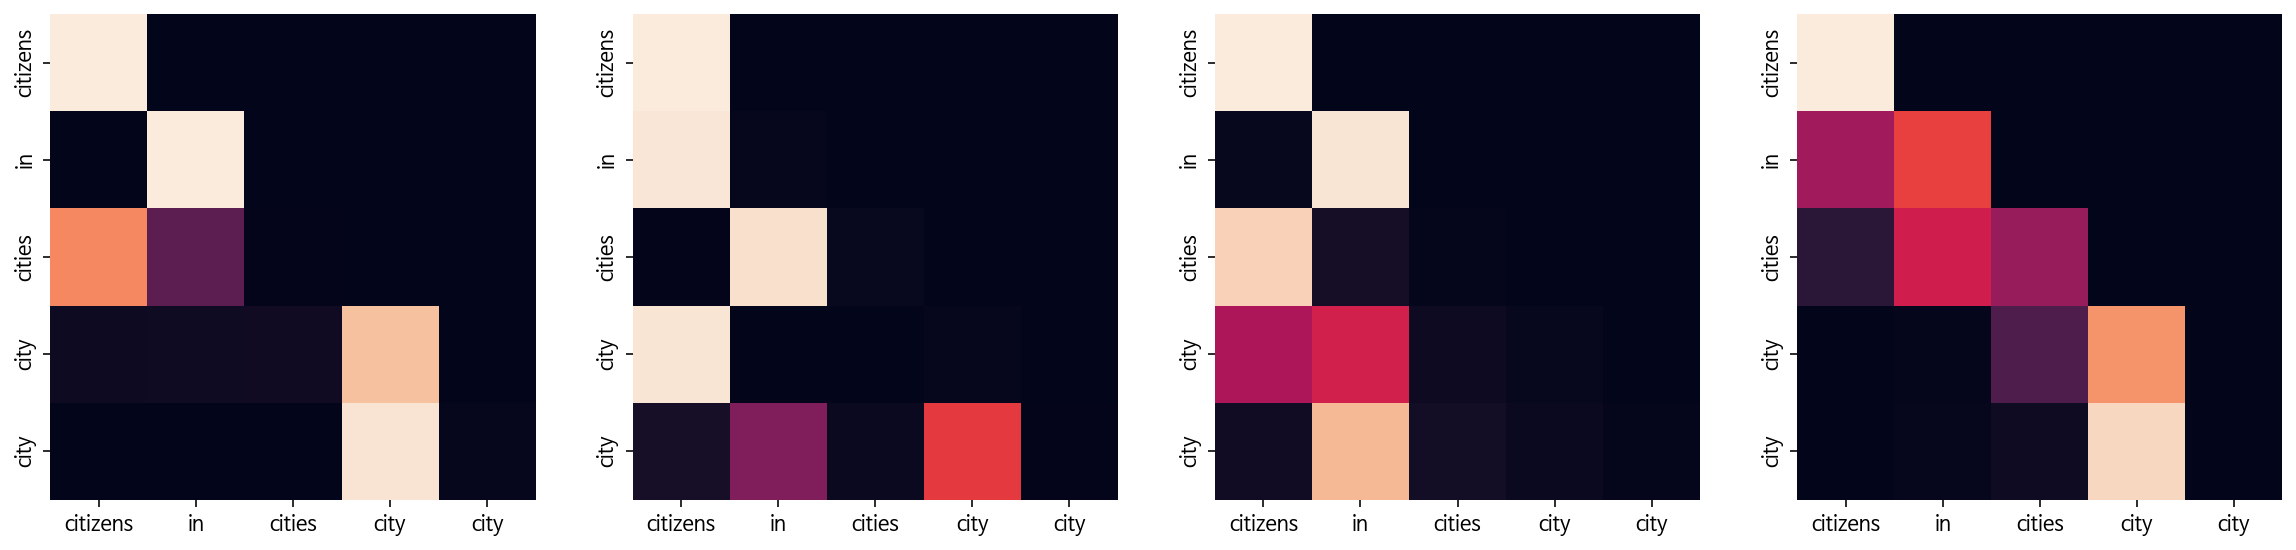

Decoder Src Layer 1


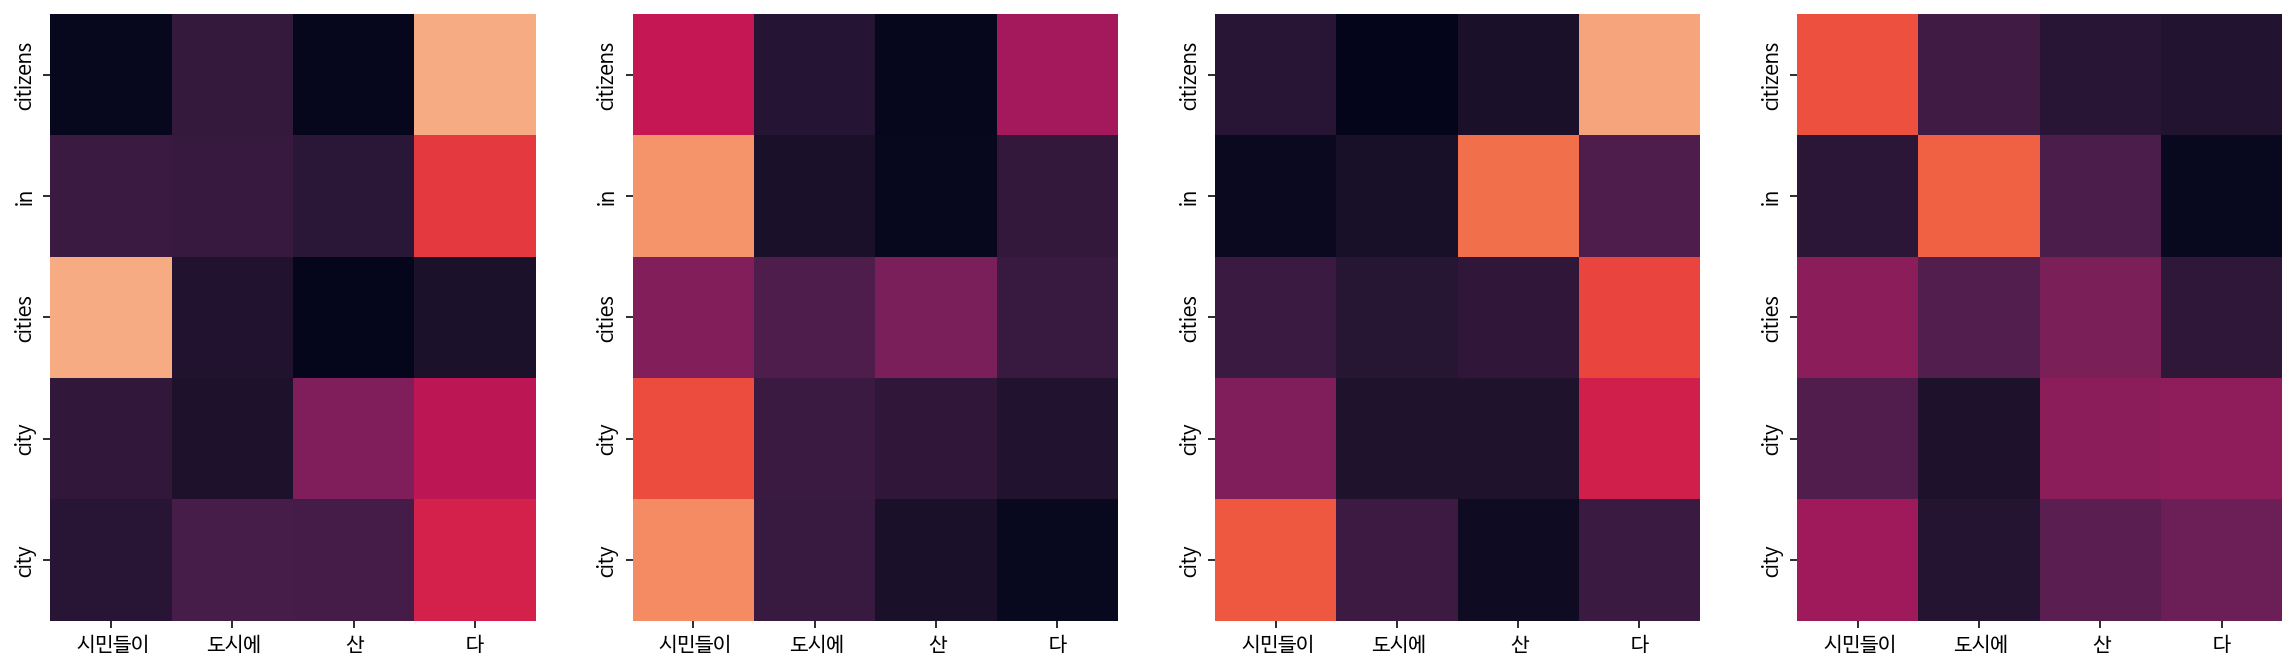

Decoder Self Layer 2


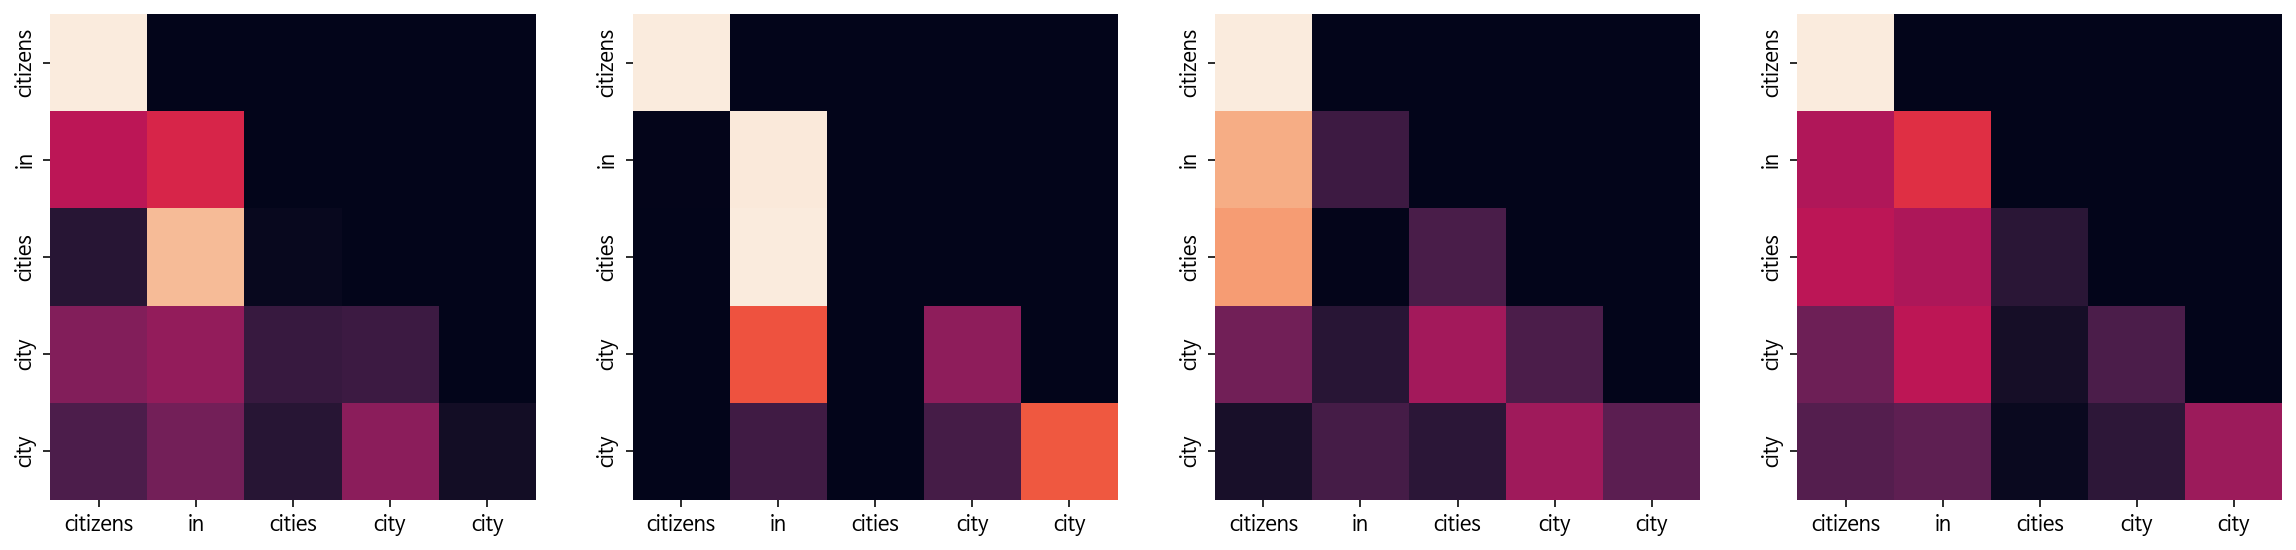

Decoder Src Layer 2


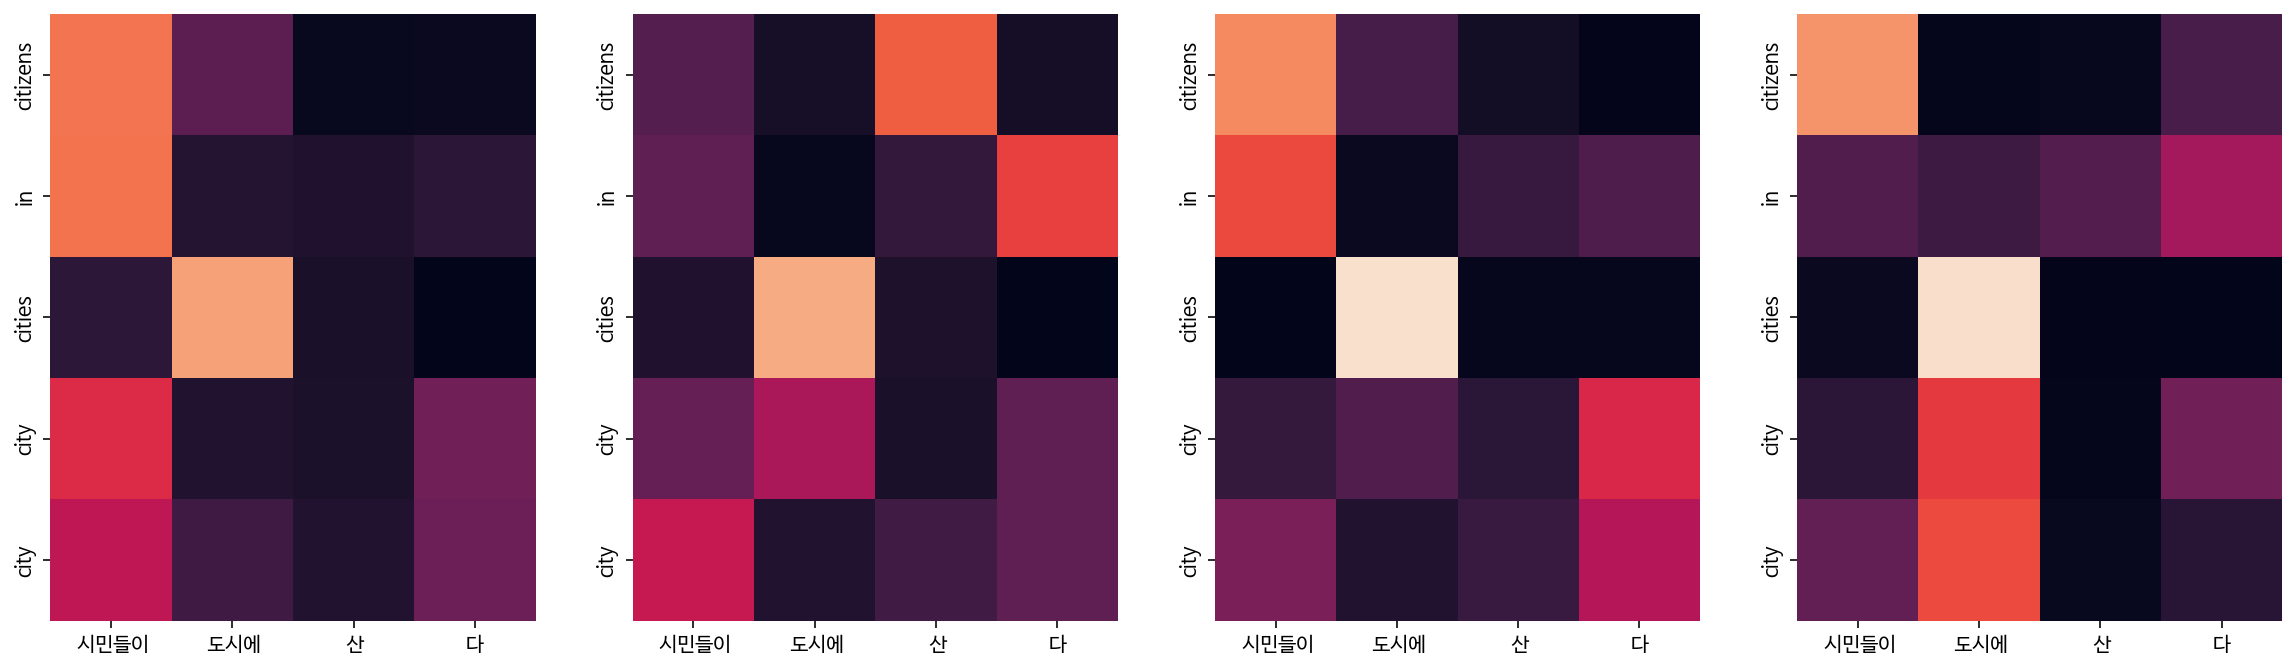

Input: 커피는 필요 없다.
Predicted translation: nobody does not want to be done
Encoder Layer 1


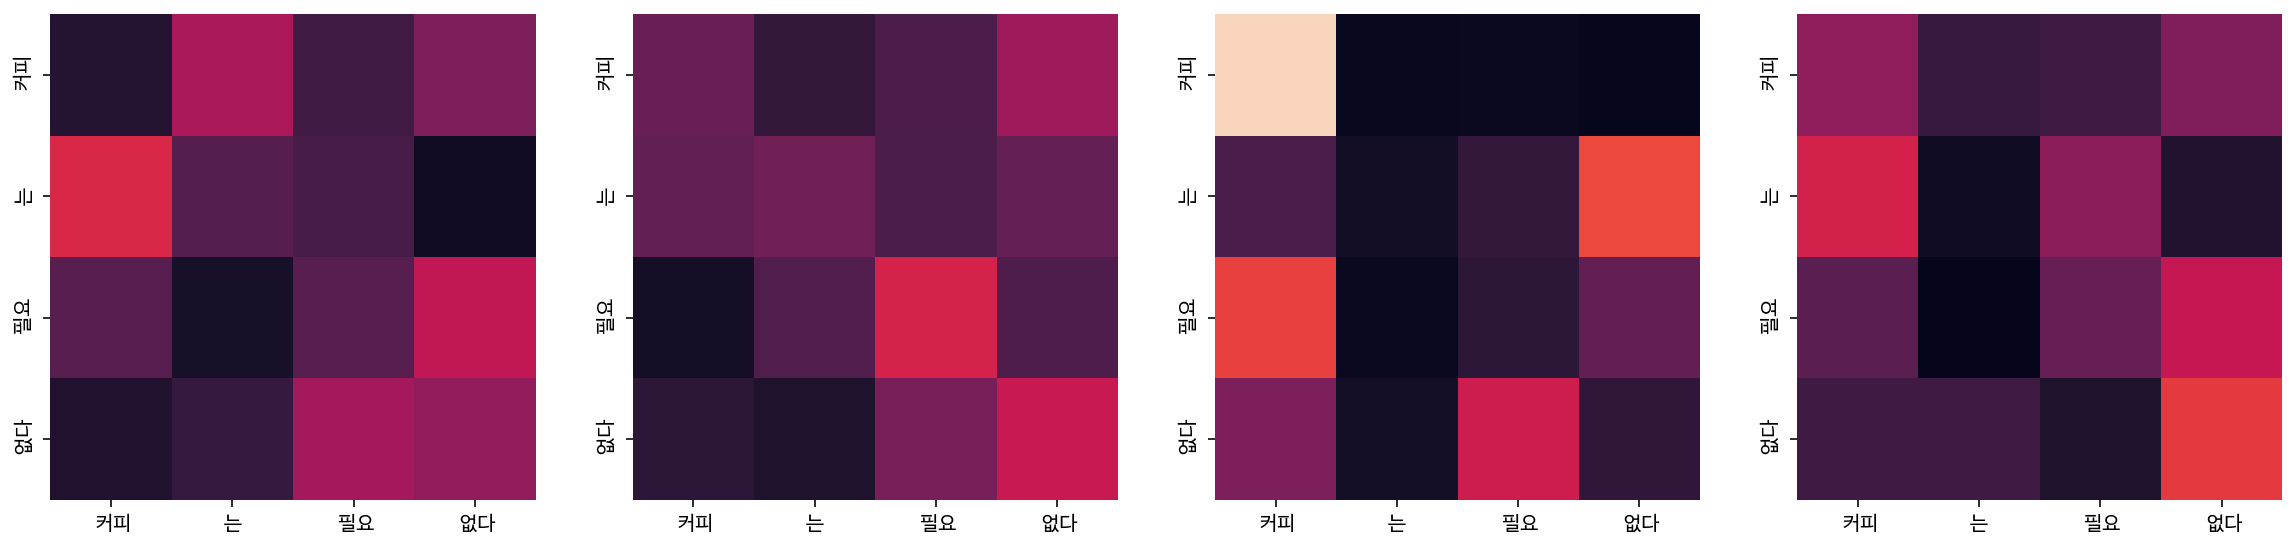

Encoder Layer 2


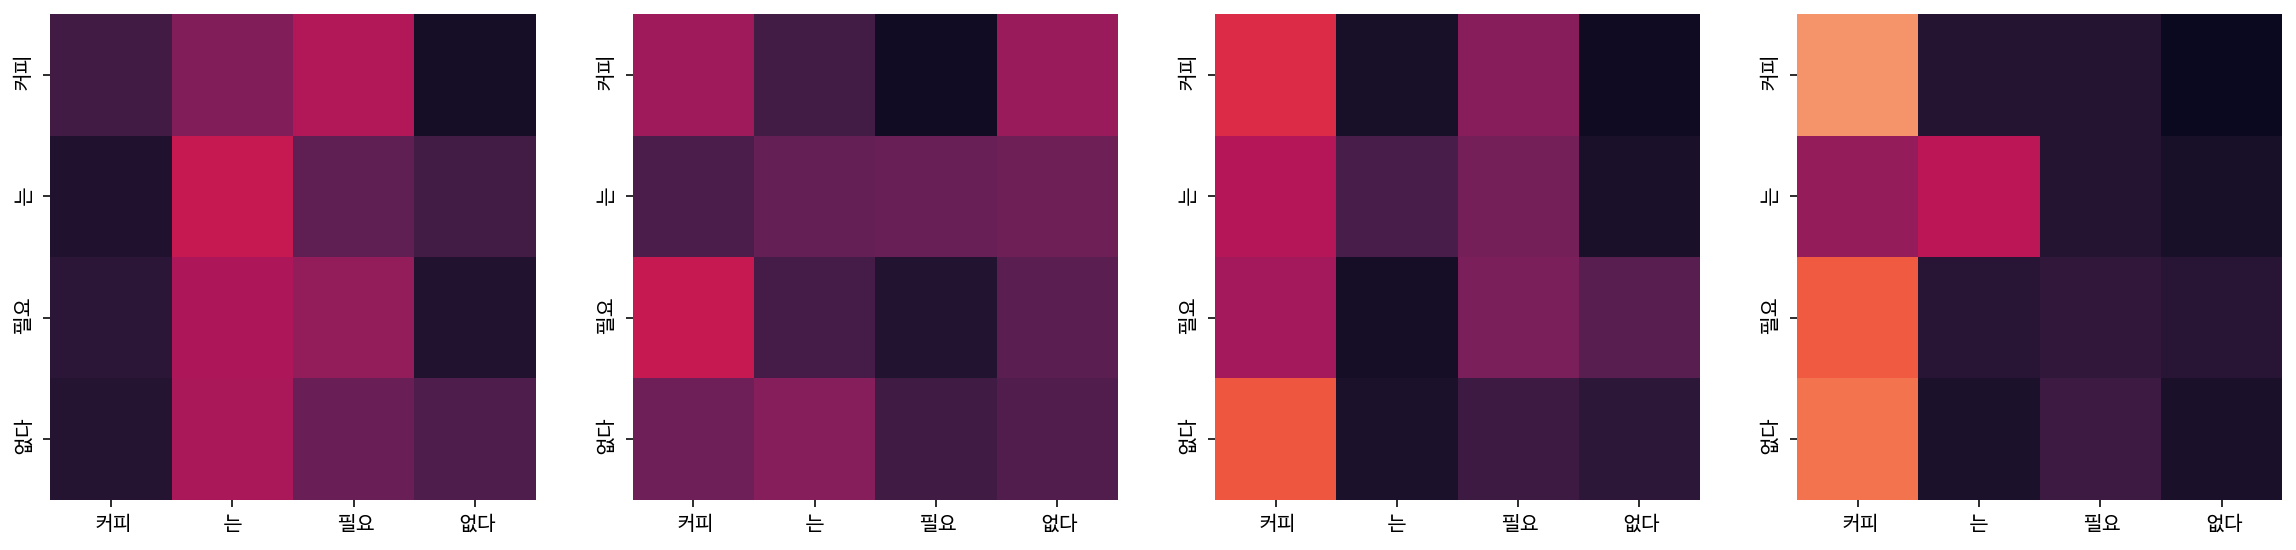

Decoder Self Layer 1


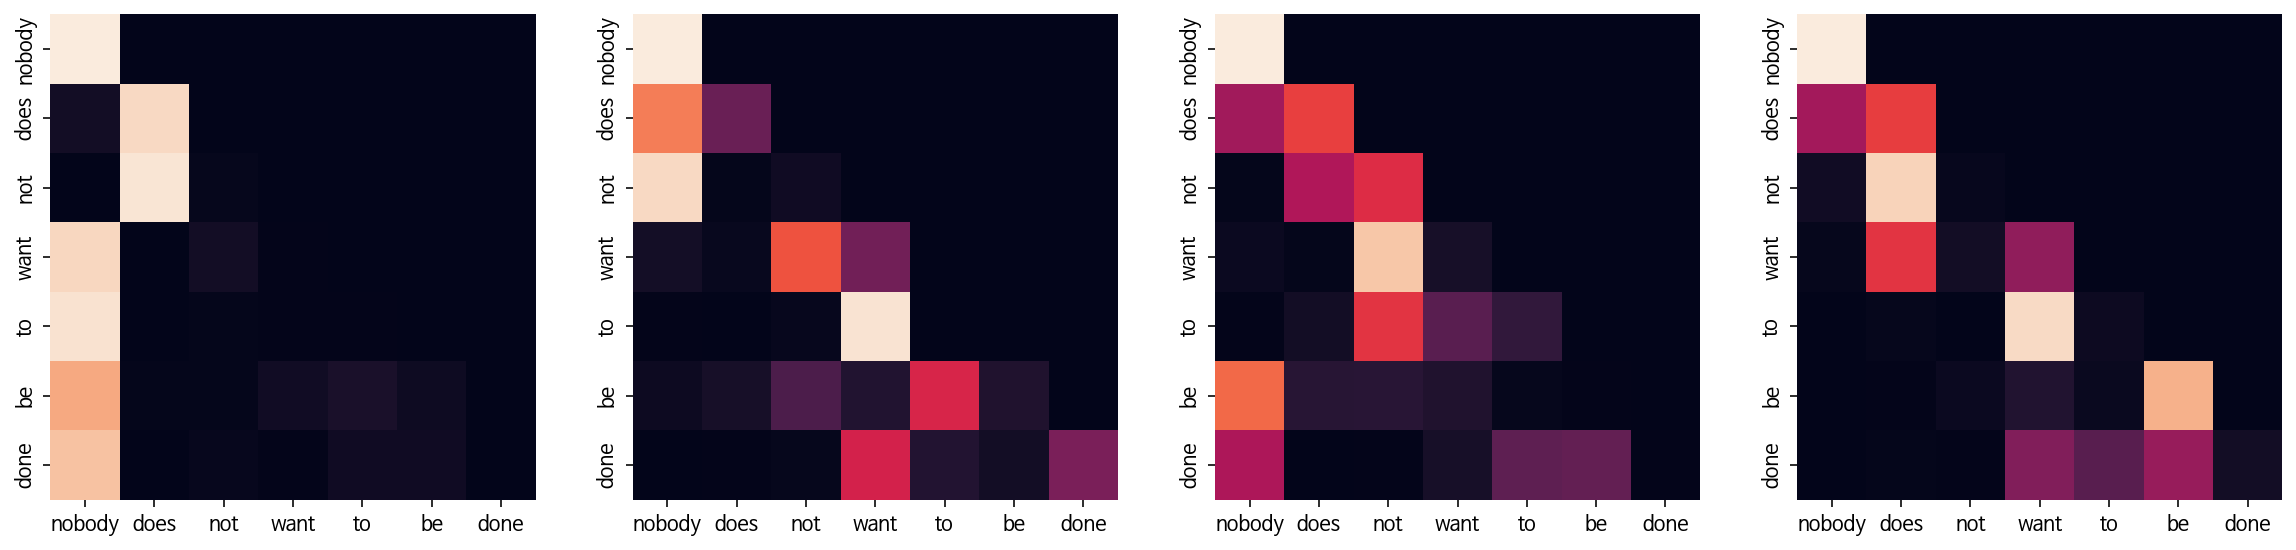

Decoder Src Layer 1


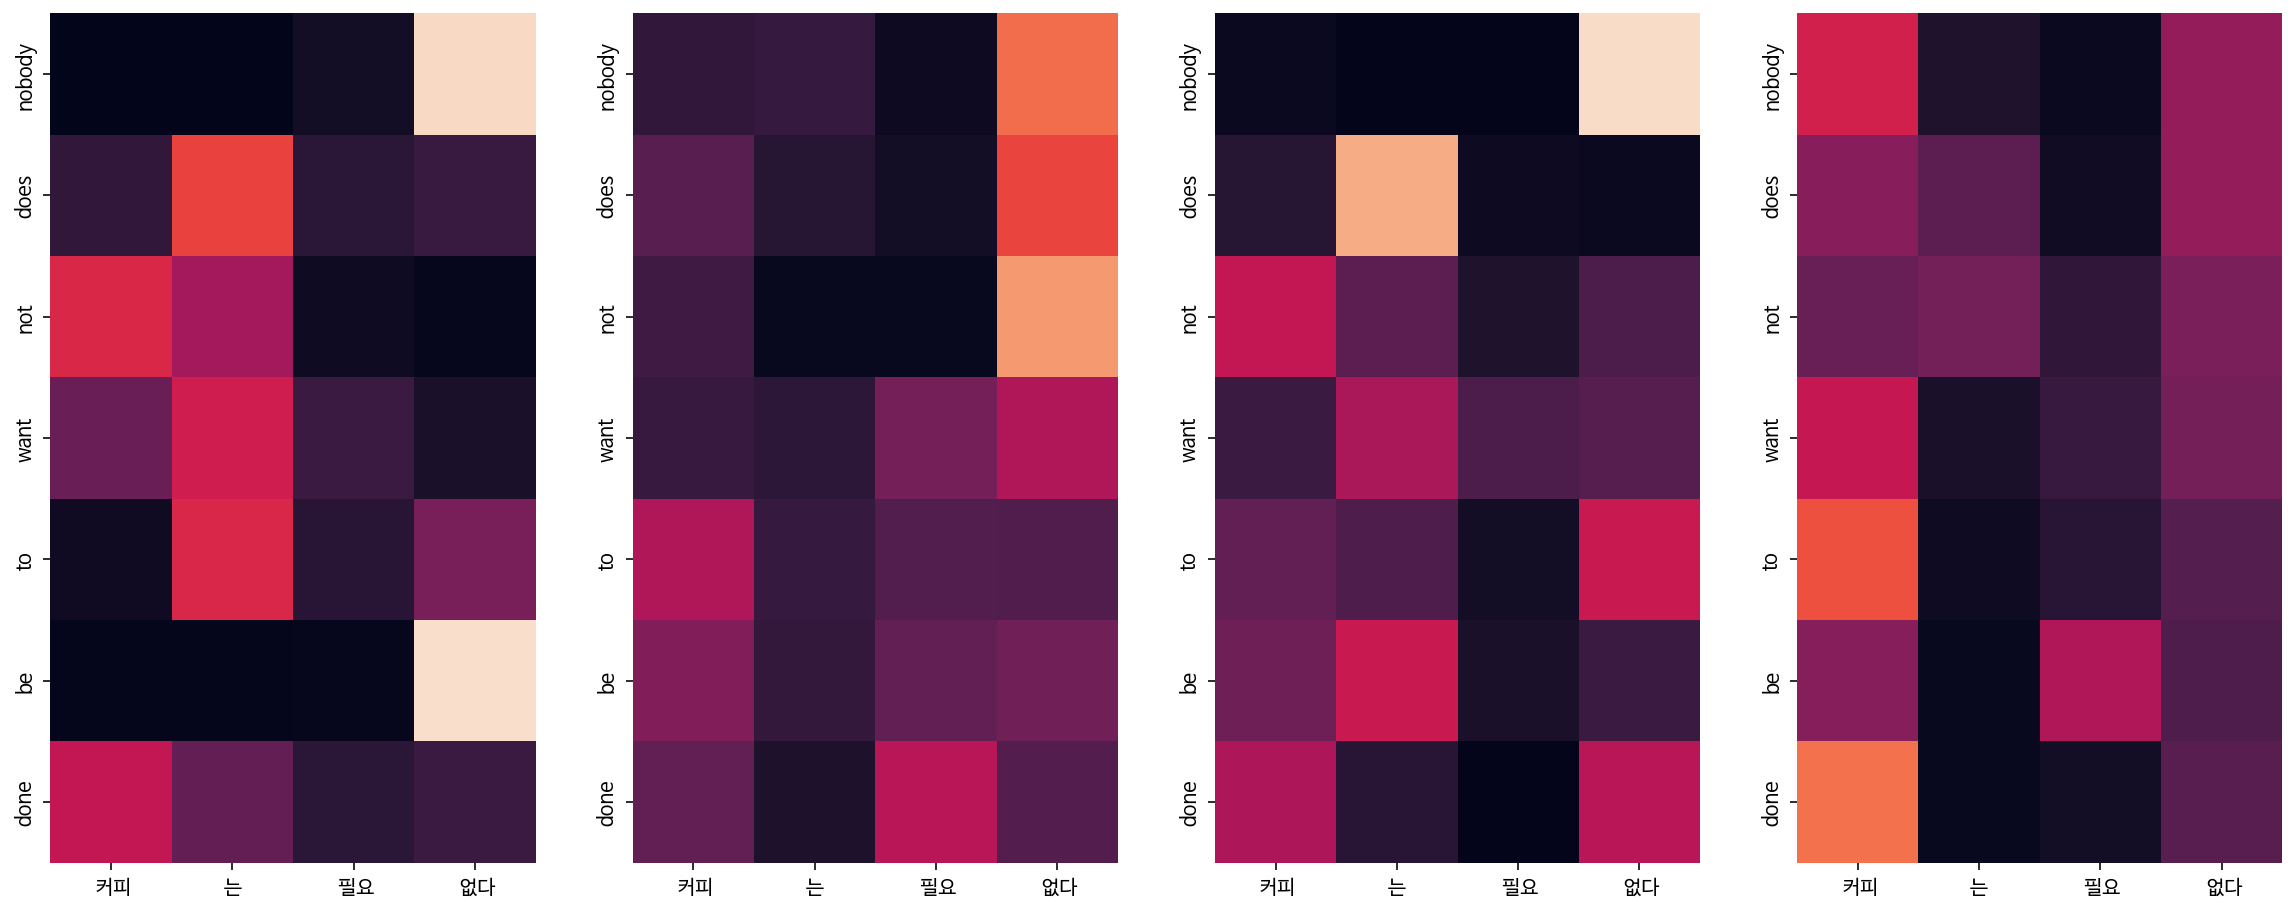

Decoder Self Layer 2


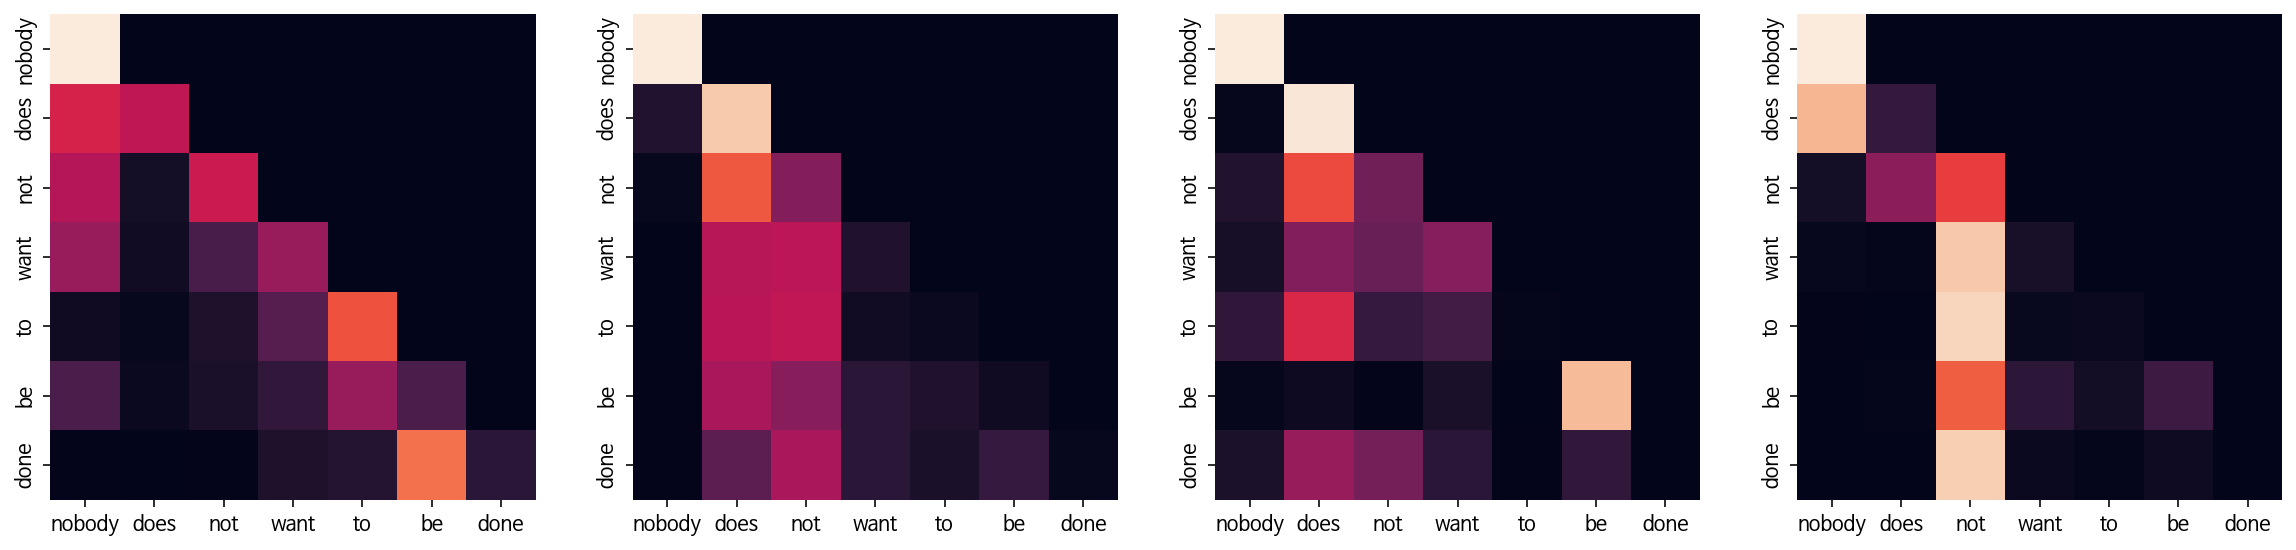

Decoder Src Layer 2


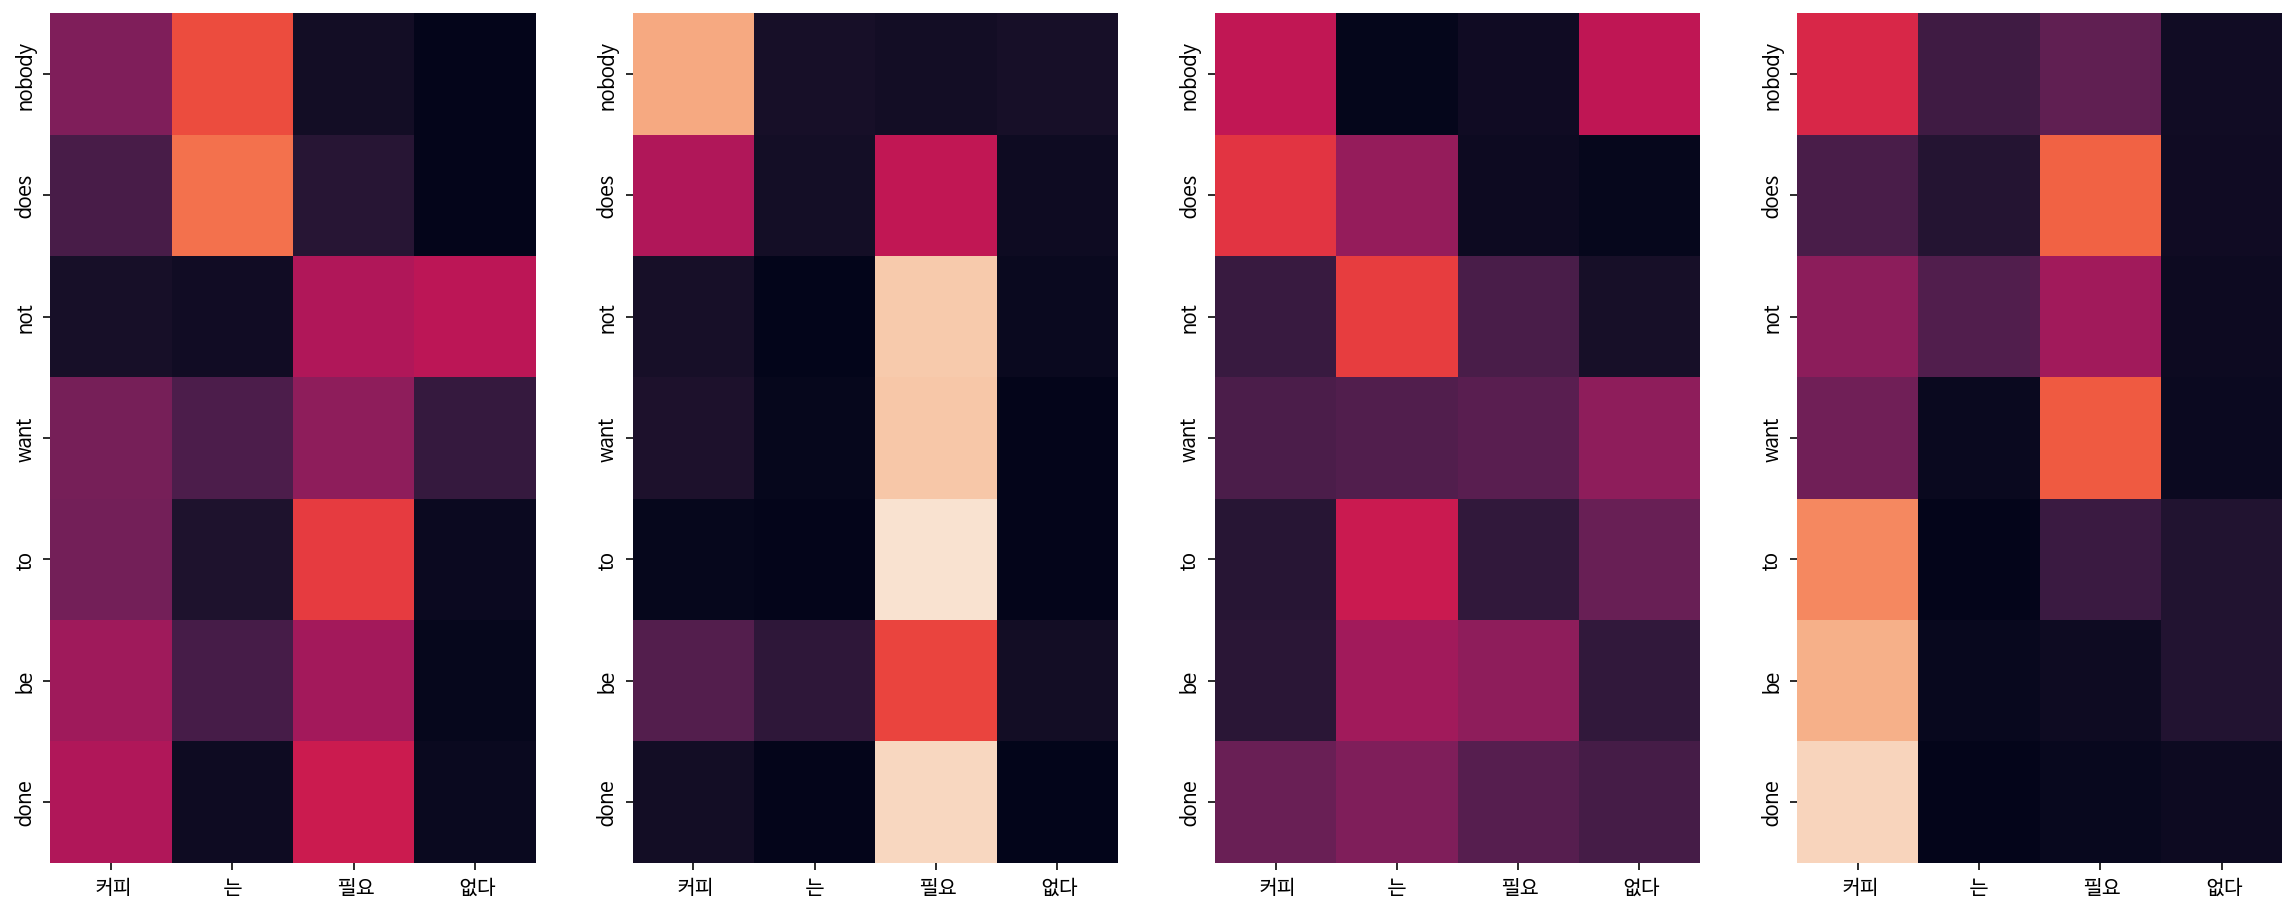

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was blamed on monday
Encoder Layer 1


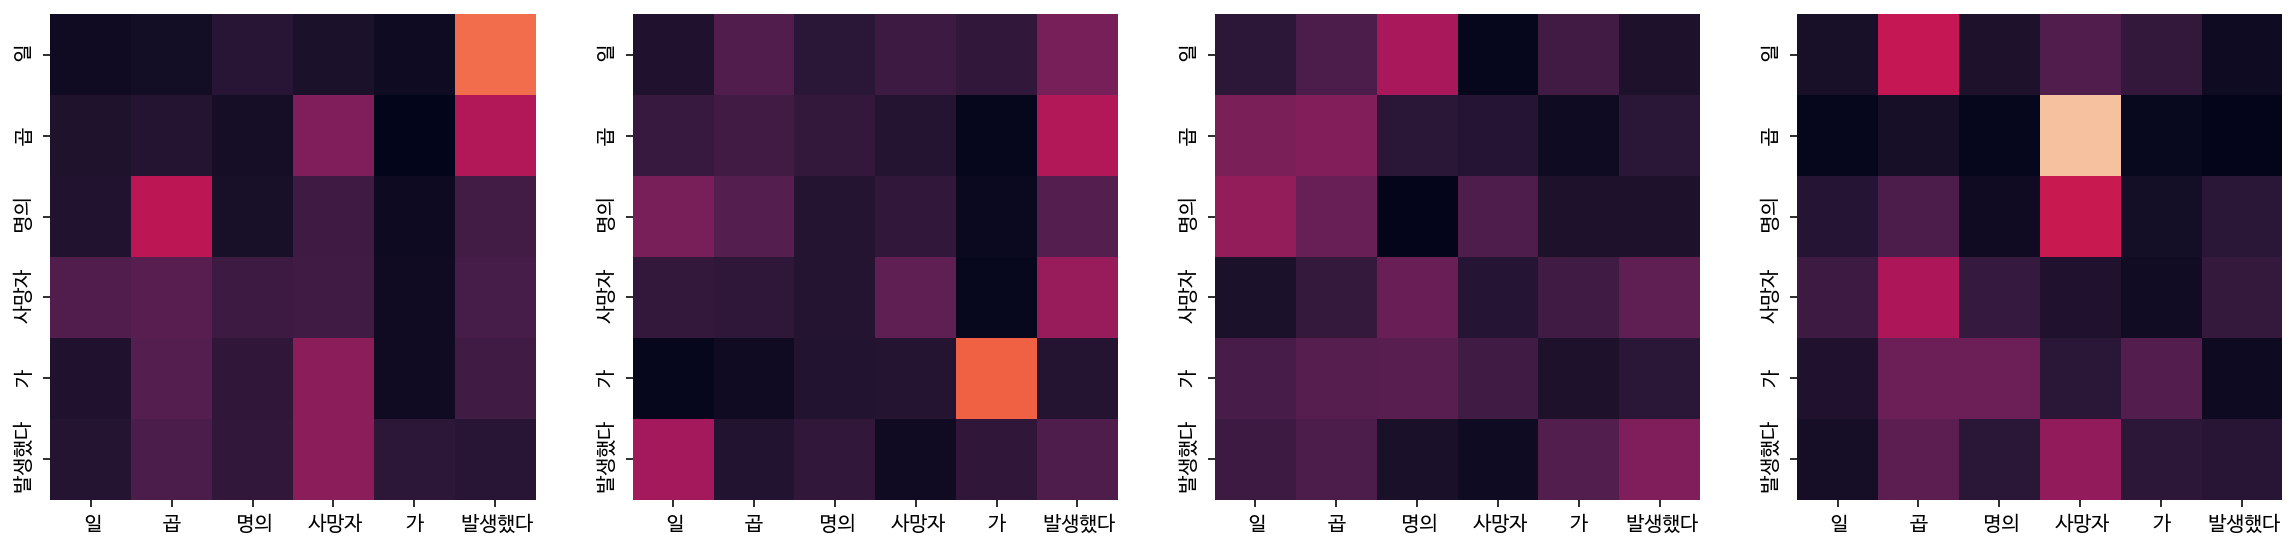

Encoder Layer 2


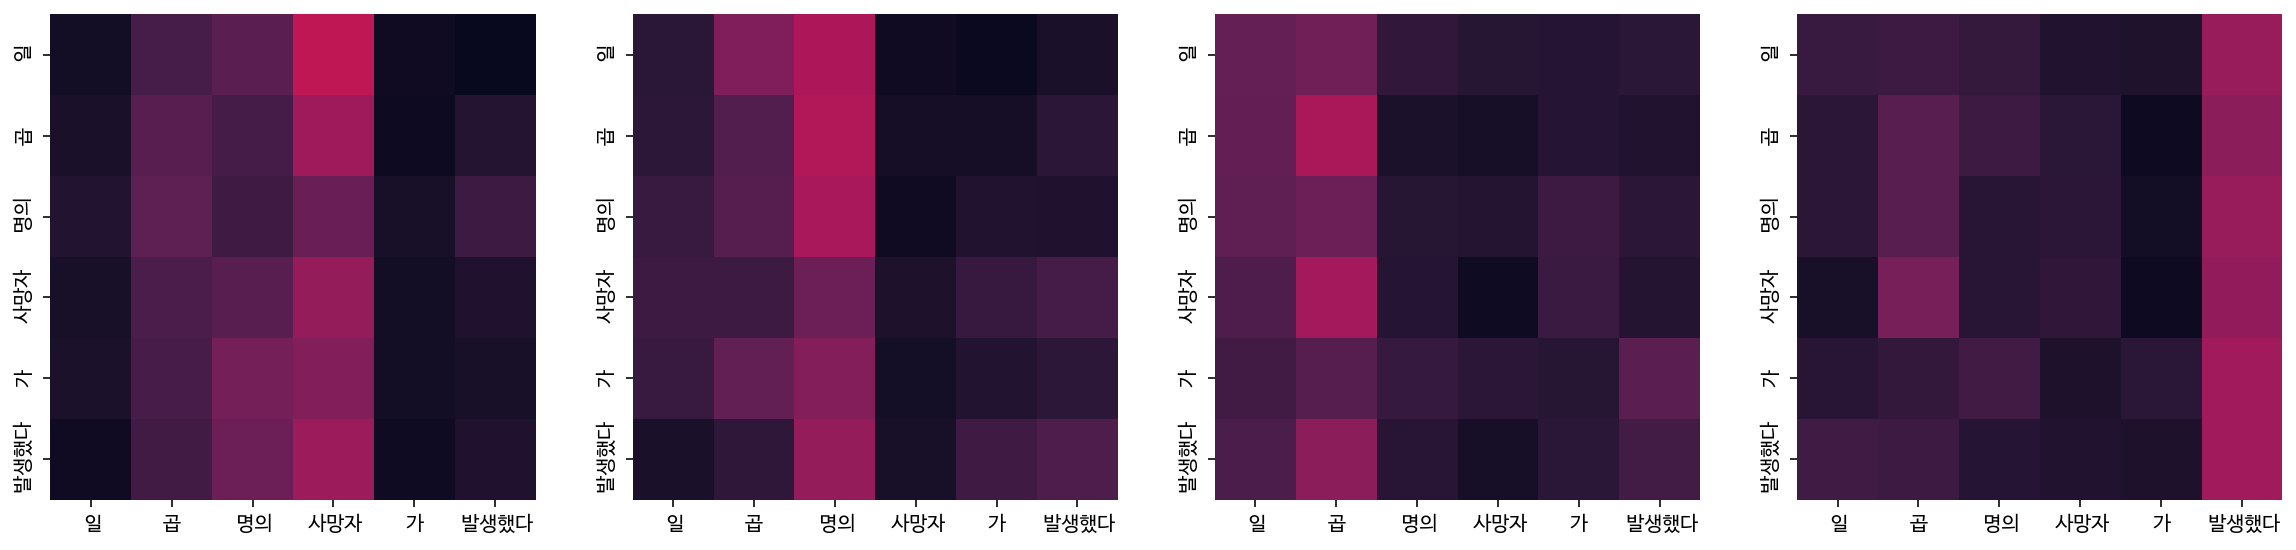

Decoder Self Layer 1


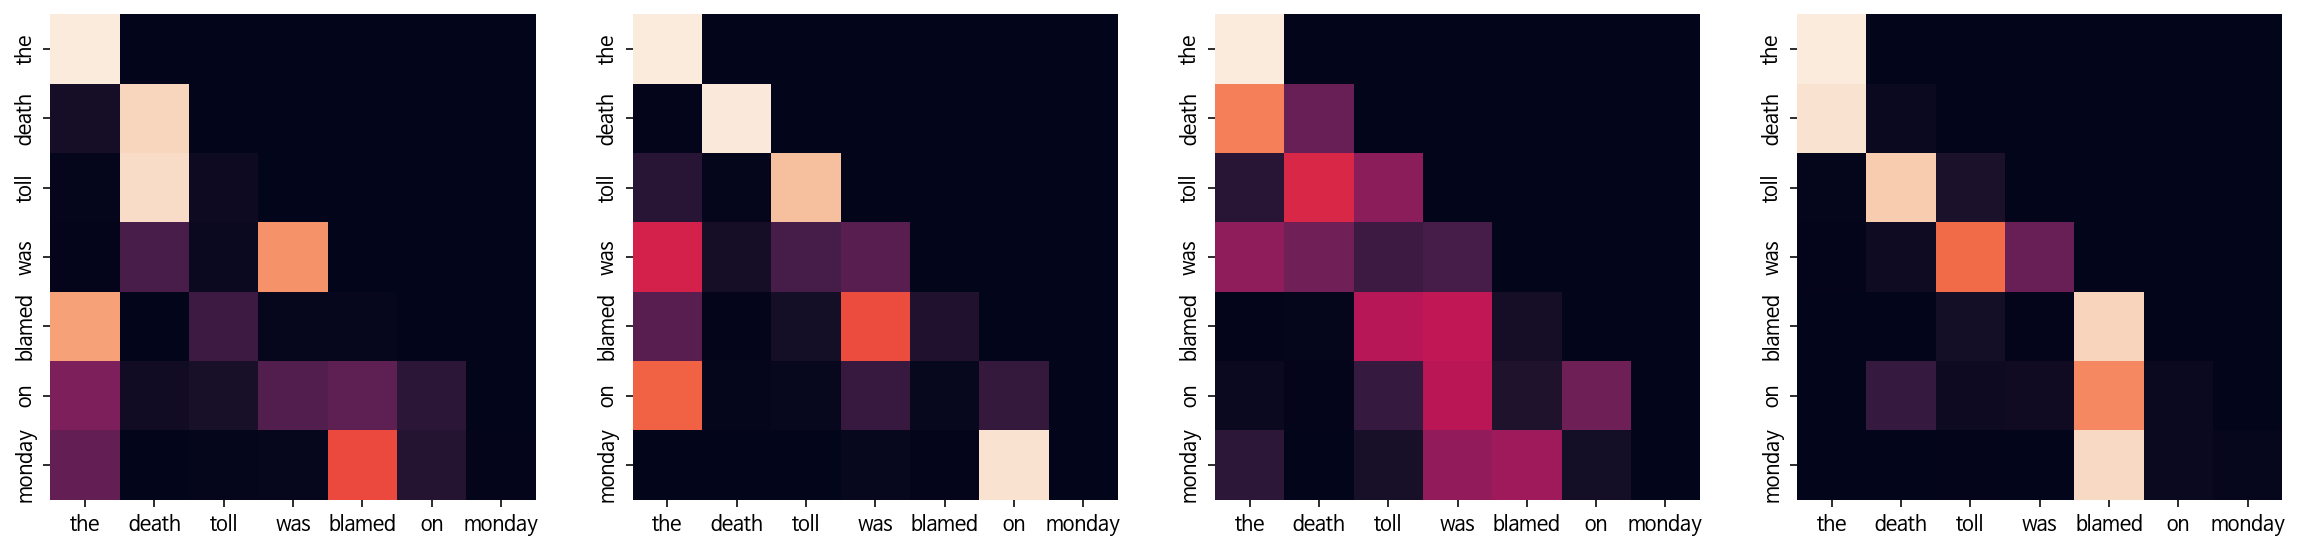

Decoder Src Layer 1


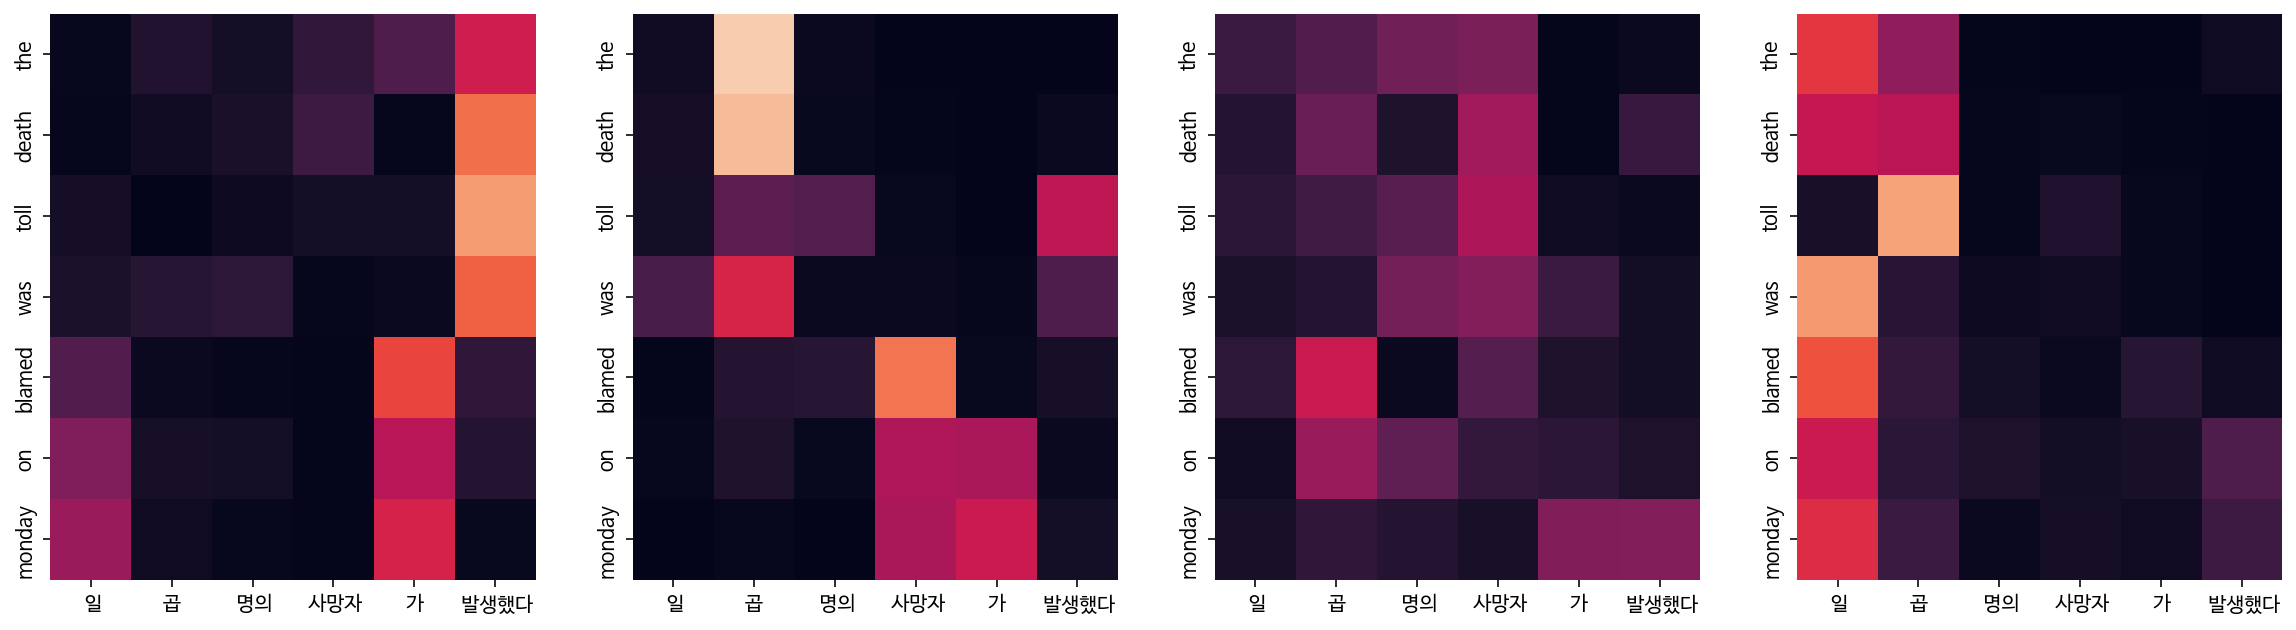

Decoder Self Layer 2


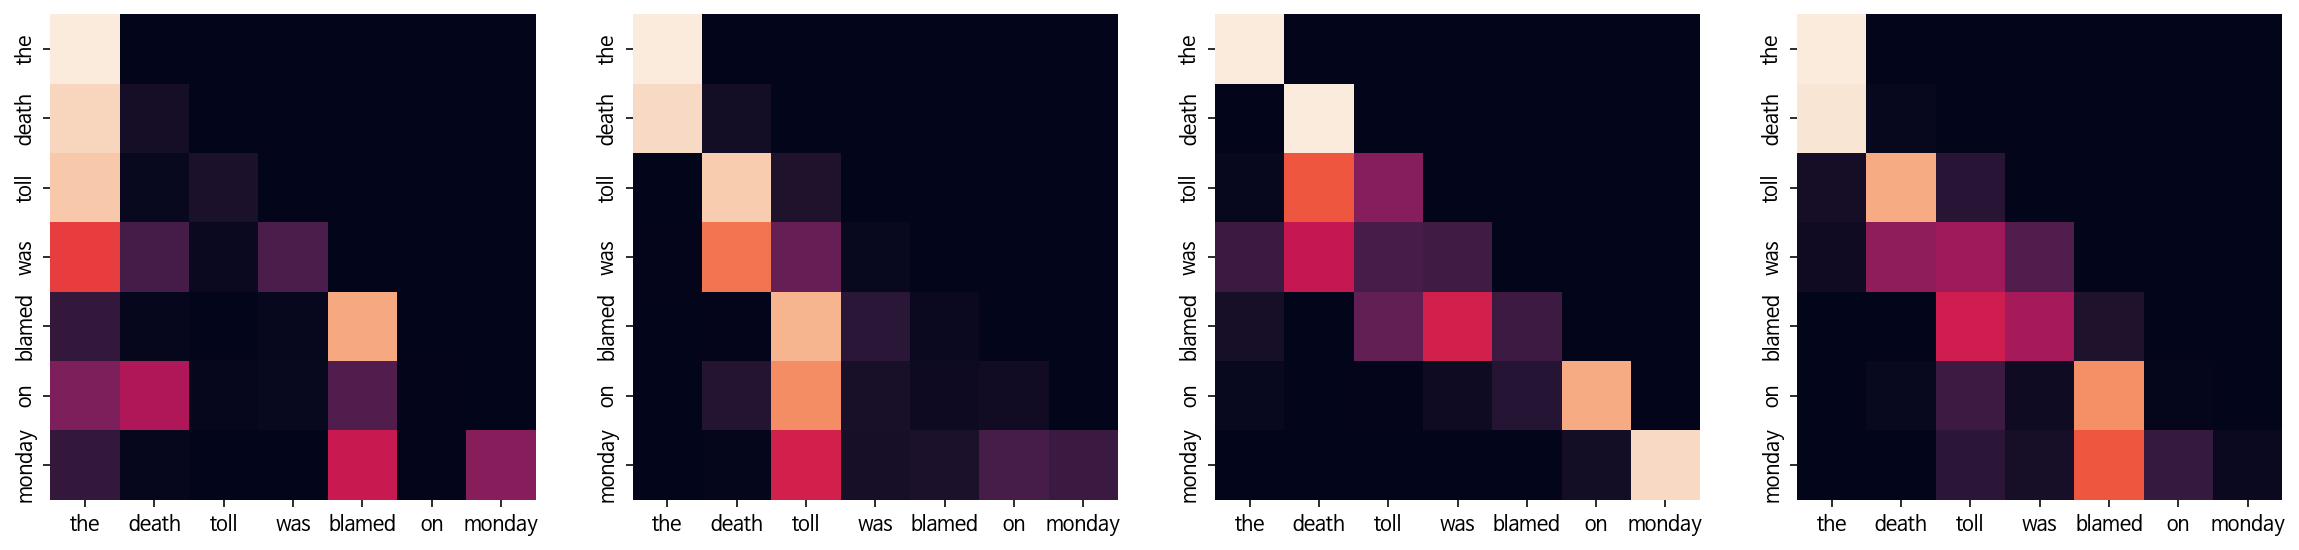

Decoder Src Layer 2


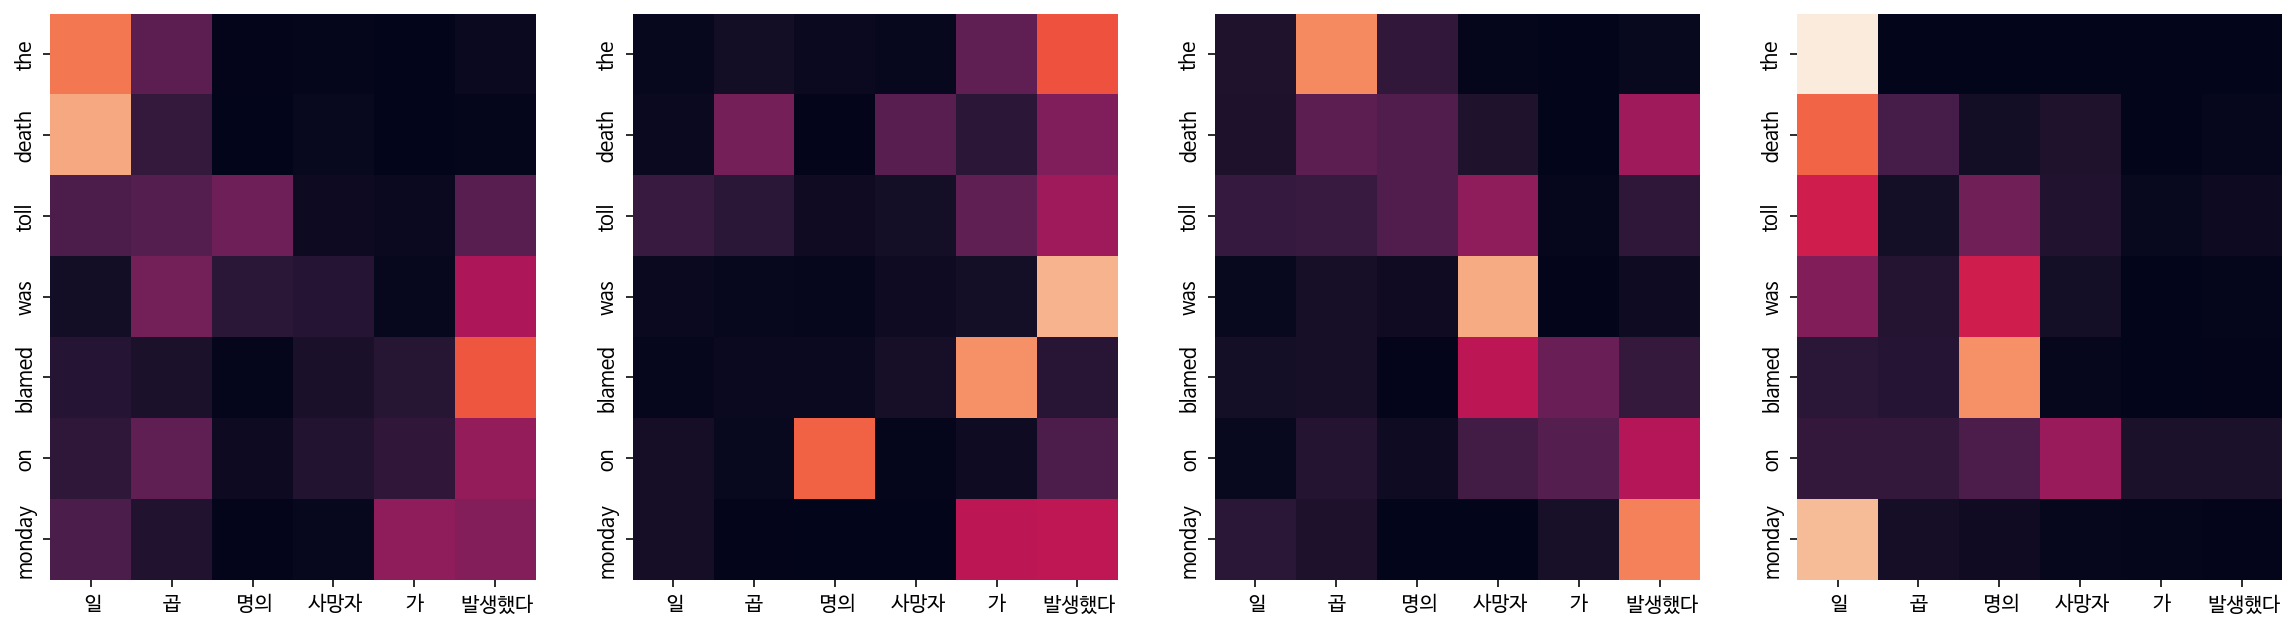

In [82]:
examples = [
            "오바마는 전 대통령이다.",
            "시민들이 도시에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, True)

#### 회고

train 때는 문제 없는데 inference 시에는 shape error 발생  
inference 때는 teacher forcing을 사용하지 않는데, 이를 고려하지 않은 마스크 적용이 `evaluate` 함수에 포함된 것으로 보이는데 이는 `evaluate` 함수를 분석해봐야 할 것 같다

(에러 수정사항)  
generate_masks 함수에서 dec_target_padding_mask를 tgt 대신 src에 맞게 생성하고 있었다. target 문장에 causality mask와 패딩을 동시에 적용해야 하는데 실수로 source 문장 shape에 맞추려고 하다보니 에러가 난 것이었다.

#### done

1. 전처리 함수
    - source & target dataset EDA
    - 일부 특수기호를 단어로 변경
    - ',', '.', 괄호 안 단어 등을 추가로 제거  

2. 에러 수정
    - 문장 번역 시 shape error가 나는 문제 해결